## Setup

In [49]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import datetime

import functools
import IPython
import IPython.display
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


import glucose_ts

# plot layouts
sns.set_context(
    "talk",
    rc={
        "axes.titlesize": 36,
        "axes.labelsize": 36,
        "lines.linewidth": 5,
        "lines.markersize": 10,
        "xtick.labelsize": 30,
        "ytick.labelsize": 30,
        'legend.fontsize': 24,
        'figsize': (20, 20),
    }
)

plt.subplots_adjust(wspace=1.5)
DATA_DIR = os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'data')

FIG_DIR = os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'presentations', 'images')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

## Load and Normalize the data


In [2]:
max_time_labeled = (20, 15)
labeled_base_path = os.path.join(DATA_DIR, 'warm_standards_hamilton')

max_time_semi_labeled = (19, 30)
semi_labeled_base_path = os.path.join(DATA_DIR, 'standards_warm')



labeled_paths = [
    os.path.join(labeled_base_path, one)
    for one in tuple(os.walk(labeled_base_path))[0][2]
    if tuple([
        int(number) 
        for number in one.split('__')[1].split('_')[:2]
    ]) < max_time_labeled
]

semi_labeled_paths = [
    os.path.join(semi_labeled_base_path, one)
    for one in tuple(os.walk(semi_labeled_base_path))[0][2]
    if tuple([
        int(number) 
        for number in one.split('__')[1].split('_')[:2]
    ]) < max_time_semi_labeled
]

labeled_curves = sorted(
    [
        glucose_ts.data.read_glucose_ts(path, {'sample_weight_glucose': 1.})
        for path in labeled_paths
    ],
    key=lambda one: one.real_concentration
)


semi_labeled_curves = sorted(
    [
        glucose_ts.data.read_glucose_ts(path, {'sample_weight_glucose': 0.2})
        for path in semi_labeled_paths
    ],
    key=lambda one: one.real_concentration
)



all_paths = [
    os.path.join(prefix, file)
    for prefix, _, files in os.walk(DATA_DIR)
    for file in files
]

unlabeled_curves = [
    glucose_ts.data.read_glucose_ts(path, {'sample_weight_glucose': 0.})
    for path in set(all_paths) - set(labeled_paths) - set(semi_labeled_paths)
]

print(
    'num labeled: %s \nnum_semi_labeled: %s \nnum unlabeled: %s' % (
        len(labeled_curves),
        len(semi_labeled_curves),
        len(unlabeled_curves)
    )
)

train_mean = np.mean(np.concatenate([one.voltages for one in unlabeled_curves]))
train_std = np.std(np.concatenate([one.voltages for one in unlabeled_curves]))




num labeled: 11 
num_semi_labeled: 10 
num unlabeled: 64


## tf.data.Dataset Windows

Pay attention when create the training validation split randomly. The validation set must not be empty.

In [5]:
import random


validation_indices = random.sample(range(len(labeled_curves)), k=4)

pure_training = [
    series 
    for idx, series in enumerate(labeled_curves) 
    if not idx in validation_indices
] + semi_labeled_curves + [
    glucose_ts.data.GlucoseTS(
        one.points_in_time,
        one.voltages,
        # this value should delabel the concentrations
        -1.,
        one.comment
    )
    for one in unlabeled_curves
]

pure_validation = [
    series 
    for idx, series in enumerate(labeled_curves)
    if idx in validation_indices
]

len(pure_training), len(pure_validation), [one.real_concentration for one in pure_validation]

(81, 4, [0.3, 0.75, 1.0, 1.25])

In [7]:
# do some thinning as we do not need a time series of 1000 points

CLUSTER_LENGTH = 10
CUT_OFF_IDX = 15

training = glucose_ts.data.tf_data_windows.dataset_ts_and_glucose_weights(
    glc_time_series=pure_training,
    batch_size=64,
    cluster_length=CLUSTER_LENGTH,
    cut_off=CUT_OFF_IDX,
    all_combinations=True,
    norm_mean=train_mean,
    norm_std=train_std,
)

validation = glucose_ts.data.tf_data_windows.dataset_ts_and_glucose(
    glc_time_series=pure_validation,
    batch_size=16,
    cluster_length=CLUSTER_LENGTH,
    cut_off=CUT_OFF_IDX,
    all_combinations=False,
    norm_mean=train_mean,
    norm_std=train_std,
)


Here we see that for the training set we pick a random point in time where we splits the time-series. For technical reasons the label sequence need to have a fixed length. 

In [8]:
[
    (
        {key: val.shape for key, val in one[0].items()},
        {key: val.shape for key, val in one[1].items()},
        {key: val.shape for key, val in one[2].items()}
    ) for one in training.take(2)
]

[({'voltage_inputs': TensorShape([64, 15, 1])},
  {'voltage_output': TensorShape([64, 85, 1]),
   'glucose_output': TensorShape([64, 1])},
  {'glucose_output': TensorShape([64, 1])}),
 ({'voltage_inputs': TensorShape([64, 15, 1])},
  {'voltage_output': TensorShape([64, 85, 1]),
   'glucose_output': TensorShape([64, 1])},
  {'glucose_output': TensorShape([64, 1])})]

# Training Loop

# Model Evaluation

I splitted the regulation between the lstm and the dense layers. I did not try dropout so far. It is just a small change though.

In [9]:
import itertools

val_performance = {}

# Good setup
def train_model(dense_reg, glucose_weight):
    print('glucose_reg_strength: %.2E \nglucose_weight: %.2E' % (dense_reg, glucose_weight))
    model = glucose_ts.models.get_semi_supervised_model(
        rnn_units=4,
        total_length=100,
        label_length=100 - CUT_OFF_IDX,
        lstm_regularization=1e-7,
        dense_ts_regularization=2e-7,
        dense_glucose_regularization=dense_reg,
        lstm_dropout=0.,
        dense_ts_dropout=0.,
        dense_glucose_dropout=0.,
        dense_ts_layer_sizes=(4, 3, 3,),
        dense_glucose_layer_sizes=(2, ),
        learning_rate=5e-4,
        voltage_weight=1.,
        glucose_weight=glucose_weight,
    )
    
    history = model.fit(
        training.shuffle(100).prefetch(tf.data.AUTOTUNE),
        validation_data=validation,
        steps_per_epoch=500,
        epochs=30,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_glucose_output_loss',
                patience=10,
                mode='min',
                restore_best_weights=True
            )]
    )
    return model

combinations = list(itertools.product([1e-3,], [ 1., 0.7, 0.5]))

with tf.device("GPU:0"):
    for param in combinations:
        
        model = train_model(*param)
        val_performance[param] = model.evaluate(validation)

    

    

# model.summary()
# glucose_ts.data.plot(validation.shuffle(100).take(1), model)

glucose_reg_strength: 1.00E-03 
glucose_weight: 1.00E+00
Epoch 1/30
500/500 [==============================] - 42s 54ms/step - loss: 0.8156 - voltage_output_loss: 1.5427 - glucose_output_loss: 0.0800 - val_loss: 2.2437 - val_voltage_output_loss: 4.2613 - val_glucose_output_loss: 0.2178
Epoch 2/30
500/500 [==============================] - 24s 48ms/step - loss: 0.6811 - voltage_output_loss: 1.3281 - glucose_output_loss: 0.0259 - val_loss: 1.9452 - val_voltage_output_loss: 3.7794 - val_glucose_output_loss: 0.1029
Epoch 3/30
500/500 [==============================] - 24s 49ms/step - loss: 0.6543 - voltage_output_loss: 1.2872 - glucose_output_loss: 0.0135 - val_loss: 1.6809 - val_voltage_output_loss: 3.3093 - val_glucose_output_loss: 0.0449
Epoch 4/30
500/500 [==============================] - 25s 50ms/step - loss: 0.6264 - voltage_output_loss: 1.2392 - glucose_output_loss: 0.0061 - val_loss: 1.7850 - val_voltage_output_loss: 3.5401 - val_glucose_output_loss: 0.0224
Epoch 5/30
500/500 [===

500/500 [==============================] - 24s 47ms/step - loss: 0.1966 - voltage_output_loss: 0.3304 - glucose_output_loss: 0.0015 - val_loss: 1.0125 - val_voltage_output_loss: 1.7104 - val_glucose_output_loss: 0.0116
Epoch 14/30
500/500 [==============================] - 25s 49ms/step - loss: 0.2615 - voltage_output_loss: 0.4408 - glucose_output_loss: 0.0014 - val_loss: 1.0031 - val_voltage_output_loss: 1.6930 - val_glucose_output_loss: 0.0135
Epoch 15/30
500/500 [==============================] - 25s 49ms/step - loss: 0.1898 - voltage_output_loss: 0.3190 - glucose_output_loss: 0.0014 - val_loss: 1.0055 - val_voltage_output_loss: 1.6985 - val_glucose_output_loss: 0.0114
Epoch 16/30
361/500 [====================>.........] - ETA: 6s - loss: 0.1858 - voltage_output_loss: 0.3121 - glucose_output_loss: 0.0013

KeyboardInterrupt: 

In [24]:
list(combinations)

[]

In [14]:
from glucose_ts.evaluation import semi_supervised_cross_validation
import itertools
import sklearn.metrics


def cv_results(glc_reg, volt_loss_weight, cut_off_idx):
    
    print('glucose regularization: %.2E \n loss_weight: %4.2f' %(glc_reg, volt_loss_weight))
    
    model_function = functools.partial(
        glucose_ts.models.get_semi_supervised_model,
        rnn_units=4,
        total_length=100,
        label_length=100 - cut_off_idx,
        lstm_regularization=1e-7,
        dense_ts_regularization=2e-7,
        dense_glucose_regularization=glc_reg,
        lstm_dropout=0.,
        dense_ts_dropout=0.,
        dense_glucose_dropout=0.,
        dense_ts_layer_sizes=(4, 3, 3,),
        dense_glucose_layer_sizes=(2, ),
        learning_rate=5e-4,
        voltage_weight=volt_loss_weight,
        glucose_weight=1.,
    )


    labels_and_predictions = semi_supervised_cross_validation(
        unlabeled_curves=unlabeled_curves,
        semi_labeled_curves=semi_labeled_curves,
        labeled_curves=labeled_curves,
        model_func=model_function,
        num_folds=11,
        cluster_length=10,
        cut_off_idx=cut_off_idx,
        num_epochs=10,
        steps_per_epoch=500,
        train_batch_size=64,
        semi_glucose_sample_weight=0.2,
    )
    
    labels_and_predictions = sorted([
        (label, float(pred))
        for label, pred in labels_and_predictions
    ])
    print(labels_and_predictions)
    
    print('RMSE: %6.4f' % math.sqrt(sklearn.metrics.mean_squared_error(*zip(*labels_and_predictions))))
    print('RMSE below 2 g / L: %6.4f' % math.sqrt(
        sklearn.metrics.mean_squared_error(
            *zip(*[
                (label, pred)
                for label, pred in labels_and_predictions
                if label < 2
            ])
        )
    ))
    return labels_and_predictions


results = dict()
with tf.device("GPU:0"):
    
    for cut_off in np.linspace(5, 95, 19):

        results[int(cut_off)] = cv_results(1e-3, 1., int(cut_off))
    

glucose regularization: 1.00E-03 
 loss_weight: 1.00
Validation Set concentrations: [0.75]
Epoch 1/10
500/500 [==============================] - 43s 54ms/step - loss: 0.5104 - voltage_output_loss: 0.6453 - glucose_output_loss: 0.3636 - val_loss: 0.3557 - val_voltage_output_loss: 0.6041 - val_glucose_output_loss: 0.0949
Epoch 2/10
500/500 [==============================] - 23s 47ms/step - loss: 0.4147 - voltage_output_loss: 0.5688 - glucose_output_loss: 0.2472 - val_loss: 0.2893 - val_voltage_output_loss: 0.5255 - val_glucose_output_loss: 0.0388
Epoch 3/10
500/500 [==============================] - 23s 46ms/step - loss: 0.3478 - voltage_output_loss: 0.5300 - glucose_output_loss: 0.1503 - val_loss: 0.1930 - val_voltage_output_loss: 0.3562 - val_glucose_output_loss: 0.0135
Epoch 4/10
500/500 [==============================] - 24s 47ms/step - loss: 0.3220 - voltage_output_loss: 0.5435 - glucose_output_loss: 0.0831 - val_loss: 0.3575 - val_voltage_output_loss: 0.6945 - val_glucose_output_lo

Epoch 6/10
500/500 [==============================] - 24s 48ms/step - loss: 0.5422 - voltage_output_loss: 1.0468 - glucose_output_loss: 0.0242 - val_loss: 0.1158 - val_voltage_output_loss: 0.1816 - val_glucose_output_loss: 0.0367
Epoch 7/10
500/500 [==============================] - 24s 48ms/step - loss: 0.5310 - voltage_output_loss: 1.0261 - glucose_output_loss: 0.0225 - val_loss: 0.1159 - val_voltage_output_loss: 0.1899 - val_glucose_output_loss: 0.0288
Epoch 8/10
500/500 [==============================] - 24s 48ms/step - loss: 0.5247 - voltage_output_loss: 1.0144 - glucose_output_loss: 0.0219 - val_loss: 0.1148 - val_voltage_output_loss: 0.1897 - val_glucose_output_loss: 0.0269
Epoch 9/10
500/500 [==============================] - 23s 46ms/step - loss: 0.5262 - voltage_output_loss: 1.0169 - glucose_output_loss: 0.0225 - val_loss: 0.1166 - val_voltage_output_loss: 0.1898 - val_glucose_output_loss: 0.0305
Epoch 10/10
500/500 [==============================] - 23s 46ms/step - loss: 0.5

Epoch 5/10
500/500 [==============================] - 24s 48ms/step - loss: 0.3142 - voltage_output_loss: 0.5410 - glucose_output_loss: 0.0714 - val_loss: 0.6428 - val_voltage_output_loss: 1.1987 - val_glucose_output_loss: 0.0695
Epoch 6/10
500/500 [==============================] - 23s 47ms/step - loss: 0.2939 - voltage_output_loss: 0.5294 - glucose_output_loss: 0.0403 - val_loss: 0.7196 - val_voltage_output_loss: 1.3539 - val_glucose_output_loss: 0.0672
Epoch 7/10
500/500 [==============================] - 24s 48ms/step - loss: 0.2883 - voltage_output_loss: 0.5274 - glucose_output_loss: 0.0316 - val_loss: 0.1689 - val_voltage_output_loss: 0.2612 - val_glucose_output_loss: 0.0598
Epoch 8/10
500/500 [==============================] - 24s 47ms/step - loss: 0.2867 - voltage_output_loss: 0.5283 - glucose_output_loss: 0.0290 - val_loss: 0.8407 - val_voltage_output_loss: 1.6091 - val_glucose_output_loss: 0.0570
Epoch 9/10
500/500 [==============================] - 23s 46ms/step - loss: 0.28

Epoch 10/10
500/500 [==============================] - 24s 47ms/step - loss: 0.3613 - voltage_output_loss: 0.6851 - glucose_output_loss: 0.0283 - val_loss: 7.8545 - val_voltage_output_loss: 15.2280 - val_glucose_output_loss: 0.4716
Validation Set concentrations: [1.0]
Epoch 1/10
500/500 [==============================] - 43s 52ms/step - loss: 0.5692 - voltage_output_loss: 0.8528 - glucose_output_loss: 0.2730 - val_loss: 1.3650 - val_voltage_output_loss: 2.5577 - val_glucose_output_loss: 0.1592
Epoch 2/10
500/500 [==============================] - 23s 46ms/step - loss: 0.3609 - voltage_output_loss: 0.5825 - glucose_output_loss: 0.1249 - val_loss: 0.8584 - val_voltage_output_loss: 1.6103 - val_glucose_output_loss: 0.0911
Epoch 3/10
500/500 [==============================] - 24s 48ms/step - loss: 0.2817 - voltage_output_loss: 0.4848 - glucose_output_loss: 0.0621 - val_loss: 1.4502 - val_voltage_output_loss: 2.8378 - val_glucose_output_loss: 0.0454
Epoch 4/10
500/500 [=====================

500/500 [==============================] - 24s 48ms/step - loss: 0.2563 - voltage_output_loss: 0.4963 - glucose_output_loss: 0.0050 - val_loss: 1.4738 - val_voltage_output_loss: 2.8843 - val_glucose_output_loss: 0.0520
Epoch 4/10
500/500 [==============================] - 24s 48ms/step - loss: 0.2557 - voltage_output_loss: 0.4971 - glucose_output_loss: 0.0032 - val_loss: 1.4837 - val_voltage_output_loss: 2.8866 - val_glucose_output_loss: 0.0699
Epoch 5/10
500/500 [==============================] - 24s 49ms/step - loss: 0.2508 - voltage_output_loss: 0.4882 - glucose_output_loss: 0.0026 - val_loss: 1.4876 - val_voltage_output_loss: 2.8847 - val_glucose_output_loss: 0.0801
Epoch 6/10
500/500 [==============================] - 23s 47ms/step - loss: 0.2508 - voltage_output_loss: 0.4889 - glucose_output_loss: 0.0024 - val_loss: 1.4943 - val_voltage_output_loss: 2.8909 - val_glucose_output_loss: 0.0874
Epoch 7/10
500/500 [==============================] - 24s 48ms/step - loss: 0.2530 - voltag

500/500 [==============================] - 24s 48ms/step - loss: 0.1923 - voltage_output_loss: 0.3722 - glucose_output_loss: 0.0055 - val_loss: 4.2779 - val_voltage_output_loss: 8.5250 - val_glucose_output_loss: 0.0238
Epoch 9/10
500/500 [==============================] - 24s 48ms/step - loss: 0.1891 - voltage_output_loss: 0.3658 - glucose_output_loss: 0.0055 - val_loss: 4.1582 - val_voltage_output_loss: 8.2878 - val_glucose_output_loss: 0.0220
Epoch 10/10
500/500 [==============================] - 24s 47ms/step - loss: 0.1854 - voltage_output_loss: 0.3587 - glucose_output_loss: 0.0056 - val_loss: 4.1301 - val_voltage_output_loss: 8.2207 - val_glucose_output_loss: 0.0330
Validation Set concentrations: [0.75]
Epoch 1/10
500/500 [==============================] - 42s 51ms/step - loss: 0.3507 - voltage_output_loss: 0.5726 - glucose_output_loss: 0.1221 - val_loss: 0.2142 - val_voltage_output_loss: 0.2981 - val_glucose_output_loss: 0.1225
Epoch 2/10
500/500 [==============================] 

Epoch 3/10
500/500 [==============================] - 23s 47ms/step - loss: 0.2403 - voltage_output_loss: 0.4556 - glucose_output_loss: 0.0164 - val_loss: 0.0958 - val_voltage_output_loss: 0.1826 - val_glucose_output_loss: 1.0615e-04
Epoch 4/10
500/500 [==============================] - 24s 49ms/step - loss: 0.2030 - voltage_output_loss: 0.3893 - glucose_output_loss: 0.0080 - val_loss: 0.1320 - val_voltage_output_loss: 0.2553 - val_glucose_output_loss: 4.5201e-05
Epoch 5/10
500/500 [==============================] - 24s 48ms/step - loss: 0.1929 - voltage_output_loss: 0.3699 - glucose_output_loss: 0.0071 - val_loss: 0.2354 - val_voltage_output_loss: 0.4621 - val_glucose_output_loss: 8.2981e-05
Epoch 6/10
500/500 [==============================] - 24s 48ms/step - loss: 0.1879 - voltage_output_loss: 0.3605 - glucose_output_loss: 0.0068 - val_loss: 0.2193 - val_voltage_output_loss: 0.4301 - val_glucose_output_loss: 7.2757e-05
Epoch 7/10
500/500 [==============================] - 24s 47ms/s

500/500 [==============================] - 24s 49ms/step - loss: 0.0924 - voltage_output_loss: 0.1767 - glucose_output_loss: 0.0027 - val_loss: 0.1959 - val_voltage_output_loss: 0.2824 - val_glucose_output_loss: 0.1040
Epoch 7/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0899 - voltage_output_loss: 0.1721 - glucose_output_loss: 0.0024 - val_loss: 0.2214 - val_voltage_output_loss: 0.3309 - val_glucose_output_loss: 0.1069
Epoch 8/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0868 - voltage_output_loss: 0.1662 - glucose_output_loss: 0.0024 - val_loss: 0.2393 - val_voltage_output_loss: 0.3631 - val_glucose_output_loss: 0.1105
Epoch 9/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0871 - voltage_output_loss: 0.1670 - glucose_output_loss: 0.0024 - val_loss: 0.2193 - val_voltage_output_loss: 0.3193 - val_glucose_output_loss: 0.1145
Epoch 10/10
500/500 [==============================] - 23s 47ms/step - loss: 0.0858 - volta

Epoch 1/10
500/500 [==============================] - 42s 52ms/step - loss: 0.4854 - voltage_output_loss: 0.7794 - glucose_output_loss: 0.1862 - val_loss: 0.3164 - val_voltage_output_loss: 0.5929 - val_glucose_output_loss: 0.0337
Epoch 2/10
500/500 [==============================] - 24s 48ms/step - loss: 0.2357 - voltage_output_loss: 0.4526 - glucose_output_loss: 0.0126 - val_loss: 0.2838 - val_voltage_output_loss: 0.5314 - val_glucose_output_loss: 0.0302
Epoch 3/10
500/500 [==============================] - 23s 47ms/step - loss: 0.2228 - voltage_output_loss: 0.4292 - glucose_output_loss: 0.0108 - val_loss: 0.1365 - val_voltage_output_loss: 0.2352 - val_glucose_output_loss: 0.0325
Epoch 4/10
500/500 [==============================] - 24s 48ms/step - loss: 0.1768 - voltage_output_loss: 0.3384 - glucose_output_loss: 0.0101 - val_loss: 0.4561 - val_voltage_output_loss: 0.8666 - val_glucose_output_loss: 0.0406
Epoch 5/10
500/500 [==============================] - 24s 48ms/step - loss: 0.15

500/500 [==============================] - 24s 49ms/step - loss: 0.2361 - voltage_output_loss: 0.4593 - glucose_output_loss: 0.0093 - val_loss: 0.0591 - val_voltage_output_loss: 0.0946 - val_glucose_output_loss: 0.0200
Epoch 7/10
500/500 [==============================] - 24s 49ms/step - loss: 0.2296 - voltage_output_loss: 0.4476 - glucose_output_loss: 0.0081 - val_loss: 0.0481 - val_voltage_output_loss: 0.0789 - val_glucose_output_loss: 0.0139
Epoch 8/10
500/500 [==============================] - 24s 48ms/step - loss: 0.1769 - voltage_output_loss: 0.3426 - glucose_output_loss: 0.0080 - val_loss: 0.0219 - val_voltage_output_loss: 0.0297 - val_glucose_output_loss: 0.0111
Epoch 9/10
500/500 [==============================] - 24s 48ms/step - loss: 0.1372 - voltage_output_loss: 0.2639 - glucose_output_loss: 0.0076 - val_loss: 0.0223 - val_voltage_output_loss: 0.0265 - val_glucose_output_loss: 0.0153
Epoch 10/10
500/500 [==============================] - 24s 47ms/step - loss: 0.1134 - volta

500/500 [==============================] - 24s 49ms/step - loss: 0.0430 - voltage_output_loss: 0.0730 - glucose_output_loss: 0.0082 - val_loss: 0.0349 - val_voltage_output_loss: 0.0621 - val_glucose_output_loss: 0.0031
Epoch 10/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0417 - voltage_output_loss: 0.0713 - glucose_output_loss: 0.0076 - val_loss: 0.0096 - val_voltage_output_loss: 0.0115 - val_glucose_output_loss: 0.0032
Validation Set concentrations: [0.1]
Epoch 1/10
500/500 [==============================] - 40s 51ms/step - loss: 0.4874 - voltage_output_loss: 0.7684 - glucose_output_loss: 0.1994 - val_loss: 0.0455 - val_voltage_output_loss: 0.0679 - val_glucose_output_loss: 0.0162
Epoch 2/10
500/500 [==============================] - 24s 48ms/step - loss: 0.2580 - voltage_output_loss: 0.4853 - glucose_output_loss: 0.0239 - val_loss: 0.0737 - val_voltage_output_loss: 0.1298 - val_glucose_output_loss: 0.0109
Epoch 3/10
500/500 [==============================] -

Epoch 4/10
500/500 [==============================] - 23s 47ms/step - loss: 0.2386 - voltage_output_loss: 0.4644 - glucose_output_loss: 0.0041 - val_loss: 0.0831 - val_voltage_output_loss: 0.1572 - val_glucose_output_loss: 6.6069e-04
Epoch 5/10
500/500 [==============================] - 24s 49ms/step - loss: 0.2340 - voltage_output_loss: 0.4558 - glucose_output_loss: 0.0041 - val_loss: 0.0780 - val_voltage_output_loss: 0.1480 - val_glucose_output_loss: 1.8490e-05
Epoch 6/10
500/500 [==============================] - 24s 49ms/step - loss: 0.2267 - voltage_output_loss: 0.4414 - glucose_output_loss: 0.0041 - val_loss: 0.0809 - val_voltage_output_loss: 0.1544 - val_glucose_output_loss: 6.9488e-06
Epoch 7/10
500/500 [==============================] - 24s 48ms/step - loss: 0.2147 - voltage_output_loss: 0.4173 - glucose_output_loss: 0.0048 - val_loss: 0.0205 - val_voltage_output_loss: 0.0284 - val_glucose_output_loss: 0.0056
Epoch 8/10
500/500 [==============================] - 24s 48ms/step 

500/500 [==============================] - 24s 48ms/step - loss: 0.0819 - voltage_output_loss: 0.1531 - glucose_output_loss: 0.0060 - val_loss: 0.1937 - val_voltage_output_loss: 0.2703 - val_glucose_output_loss: 0.1125
Epoch 10/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0794 - voltage_output_loss: 0.1487 - glucose_output_loss: 0.0054 - val_loss: 0.1552 - val_voltage_output_loss: 0.2041 - val_glucose_output_loss: 0.1017
Validation Set concentrations: [0.4]
Epoch 1/10
500/500 [==============================] - 40s 52ms/step - loss: 0.3362 - voltage_output_loss: 0.6147 - glucose_output_loss: 0.0472 - val_loss: 0.0214 - val_voltage_output_loss: 0.0066 - val_glucose_output_loss: 0.0264
Epoch 2/10
500/500 [==============================] - 24s 48ms/step - loss: 0.1981 - voltage_output_loss: 0.3676 - glucose_output_loss: 0.0195 - val_loss: 0.0225 - val_voltage_output_loss: 0.0130 - val_glucose_output_loss: 0.0232
Epoch 3/10
500/500 [==============================] -

500/500 [==============================] - 23s 46ms/step - loss: 0.1767 - voltage_output_loss: 0.3432 - glucose_output_loss: 0.0058 - val_loss: 4.1377 - val_voltage_output_loss: 7.8657 - val_glucose_output_loss: 0.4050
Epoch 3/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0814 - voltage_output_loss: 0.1536 - glucose_output_loss: 0.0043 - val_loss: 1.8519 - val_voltage_output_loss: 3.2567 - val_glucose_output_loss: 0.4423
Epoch 4/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0497 - voltage_output_loss: 0.0911 - glucose_output_loss: 0.0038 - val_loss: 1.2509 - val_voltage_output_loss: 2.0856 - val_glucose_output_loss: 0.4118
Epoch 5/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0428 - voltage_output_loss: 0.0779 - glucose_output_loss: 0.0035 - val_loss: 1.1283 - val_voltage_output_loss: 1.8894 - val_glucose_output_loss: 0.3632
Epoch 6/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0383 - voltag

Epoch 7/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0342 - voltage_output_loss: 0.0480 - glucose_output_loss: 0.0139 - val_loss: 0.0182 - val_voltage_output_loss: 0.0065 - val_glucose_output_loss: 0.0236
Epoch 8/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0302 - voltage_output_loss: 0.0408 - glucose_output_loss: 0.0134 - val_loss: 0.0150 - val_voltage_output_loss: 0.0017 - val_glucose_output_loss: 0.0223
Epoch 9/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0297 - voltage_output_loss: 0.0402 - glucose_output_loss: 0.0132 - val_loss: 0.0139 - val_voltage_output_loss: 0.0023 - val_glucose_output_loss: 0.0198
Epoch 10/10
500/500 [==============================] - 23s 47ms/step - loss: 0.0277 - voltage_output_loss: 0.0371 - glucose_output_loss: 0.0127 - val_loss: 0.0139 - val_voltage_output_loss: 9.2305e-04 - val_glucose_output_loss: 0.0215
Validation Set concentrations: [0.3]
Epoch 1/10
500/500 [==================

Epoch 2/10
500/500 [==============================] - 23s 46ms/step - loss: 0.2672 - voltage_output_loss: 0.4807 - glucose_output_loss: 0.0454 - val_loss: 0.0346 - val_voltage_output_loss: 0.0512 - val_glucose_output_loss: 0.0097
Epoch 3/10
500/500 [==============================] - 24s 48ms/step - loss: 0.2464 - voltage_output_loss: 0.4629 - glucose_output_loss: 0.0216 - val_loss: 0.0353 - val_voltage_output_loss: 0.0449 - val_glucose_output_loss: 0.0174
Epoch 4/10
500/500 [==============================] - 24s 48ms/step - loss: 0.1999 - voltage_output_loss: 0.3770 - glucose_output_loss: 0.0146 - val_loss: 0.0158 - val_voltage_output_loss: 0.0145 - val_glucose_output_loss: 0.0089
Epoch 5/10
500/500 [==============================] - 24s 48ms/step - loss: 0.1708 - voltage_output_loss: 0.3235 - glucose_output_loss: 0.0099 - val_loss: 0.0114 - val_voltage_output_loss: 0.0040 - val_glucose_output_loss: 0.0106
Epoch 6/10
500/500 [==============================] - 24s 49ms/step - loss: 0.10

Epoch 7/10
500/500 [==============================] - 24s 48ms/step - loss: 0.1271 - voltage_output_loss: 0.2401 - glucose_output_loss: 0.0040 - val_loss: 0.1176 - val_voltage_output_loss: 0.2204 - val_glucose_output_loss: 0.0046
Epoch 8/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0562 - voltage_output_loss: 0.0991 - glucose_output_loss: 0.0032 - val_loss: 0.1470 - val_voltage_output_loss: 0.2833 - val_glucose_output_loss: 0.0010
Epoch 9/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0464 - voltage_output_loss: 0.0797 - glucose_output_loss: 0.0037 - val_loss: 0.1471 - val_voltage_output_loss: 0.2828 - val_glucose_output_loss: 0.0021
Epoch 10/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0428 - voltage_output_loss: 0.0720 - glucose_output_loss: 0.0047 - val_loss: 0.2221 - val_voltage_output_loss: 0.4288 - val_glucose_output_loss: 0.0068
[(0, 0.1176062598824501), (0.05, 0.19647283852100372), (0.1, 0.1779868453741073

500/500 [==============================] - 24s 48ms/step - loss: 0.0366 - voltage_output_loss: 0.0576 - glucose_output_loss: 0.0110 - val_loss: 0.0066 - val_voltage_output_loss: 0.0019 - val_glucose_output_loss: 0.0070
Validation Set concentrations: [2.5]
Epoch 1/10
500/500 [==============================] - 40s 52ms/step - loss: 0.3314 - voltage_output_loss: 0.6283 - glucose_output_loss: 0.0271 - val_loss: 6.0197 - val_voltage_output_loss: 11.3757 - val_glucose_output_loss: 0.6574
Epoch 2/10
500/500 [==============================] - 24s 48ms/step - loss: 0.1194 - voltage_output_loss: 0.2217 - glucose_output_loss: 0.0114 - val_loss: 1.9505 - val_voltage_output_loss: 3.5030 - val_glucose_output_loss: 0.3928
Epoch 3/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0445 - voltage_output_loss: 0.0770 - glucose_output_loss: 0.0069 - val_loss: 1.2616 - val_voltage_output_loss: 2.0966 - val_glucose_output_loss: 0.4217
Epoch 4/10
500/500 [==============================] -

Epoch 5/10
500/500 [==============================] - 24s 47ms/step - loss: 0.1967 - voltage_output_loss: 0.3792 - glucose_output_loss: 0.0073 - val_loss: 0.0128 - val_voltage_output_loss: 0.0191 - val_glucose_output_loss: 1.6343e-05
Epoch 6/10
500/500 [==============================] - 25s 50ms/step - loss: 0.1534 - voltage_output_loss: 0.2927 - glucose_output_loss: 0.0079 - val_loss: 0.0117 - val_voltage_output_loss: 0.0170 - val_glucose_output_loss: 5.5401e-04
Epoch 7/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0747 - voltage_output_loss: 0.1330 - glucose_output_loss: 0.0107 - val_loss: 0.0192 - val_voltage_output_loss: 0.0210 - val_glucose_output_loss: 0.0120
Epoch 8/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0567 - voltage_output_loss: 0.0979 - glucose_output_loss: 0.0103 - val_loss: 0.0151 - val_voltage_output_loss: 0.0148 - val_glucose_output_loss: 0.0104
Epoch 9/10
500/500 [==============================] - 24s 49ms/step - lo

Epoch 10/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0336 - voltage_output_loss: 0.0472 - glucose_output_loss: 0.0140 - val_loss: 0.0248 - val_voltage_output_loss: 0.0064 - val_glucose_output_loss: 0.0372
Validation Set concentrations: [0.4]
Epoch 1/10
500/500 [==============================] - 39s 52ms/step - loss: 0.4114 - voltage_output_loss: 0.7076 - glucose_output_loss: 0.1064 - val_loss: 0.1083 - val_voltage_output_loss: 0.1531 - val_glucose_output_loss: 0.0547
Epoch 2/10
500/500 [==============================] - 24s 48ms/step - loss: 0.2775 - voltage_output_loss: 0.5204 - glucose_output_loss: 0.0262 - val_loss: 0.0476 - val_voltage_output_loss: 0.0384 - val_glucose_output_loss: 0.0487
Epoch 3/10
500/500 [==============================] - 24s 49ms/step - loss: 0.2290 - voltage_output_loss: 0.4303 - glucose_output_loss: 0.0197 - val_loss: 0.0287 - val_voltage_output_loss: 0.0096 - val_glucose_output_loss: 0.0400
Epoch 4/10
500/500 [======================

500/500 [==============================] - 24s 49ms/step - loss: 0.1167 - voltage_output_loss: 0.2166 - glucose_output_loss: 0.0118 - val_loss: 0.0147 - val_voltage_output_loss: 0.0032 - val_glucose_output_loss: 0.0210
Epoch 4/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0492 - voltage_output_loss: 0.0808 - glucose_output_loss: 0.0122 - val_loss: 0.0181 - val_voltage_output_loss: 0.0070 - val_glucose_output_loss: 0.0237
Epoch 5/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0397 - voltage_output_loss: 0.0615 - glucose_output_loss: 0.0124 - val_loss: 0.0201 - val_voltage_output_loss: 0.0092 - val_glucose_output_loss: 0.0255
Epoch 6/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0322 - voltage_output_loss: 0.0466 - glucose_output_loss: 0.0122 - val_loss: 0.0230 - val_voltage_output_loss: 0.0123 - val_glucose_output_loss: 0.0281
Epoch 7/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0273 - voltag

500/500 [==============================] - 24s 49ms/step - loss: 0.0224 - voltage_output_loss: 0.0275 - glucose_output_loss: 0.0067 - val_loss: 0.0160 - val_voltage_output_loss: 8.7227e-04 - val_glucose_output_loss: 0.0209
Epoch 9/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0203 - voltage_output_loss: 0.0238 - glucose_output_loss: 0.0066 - val_loss: 0.0153 - val_voltage_output_loss: 5.0749e-04 - val_glucose_output_loss: 0.0201
Epoch 10/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0186 - voltage_output_loss: 0.0209 - glucose_output_loss: 0.0066 - val_loss: 0.0140 - val_voltage_output_loss: 6.1309e-04 - val_glucose_output_loss: 0.0180
Validation Set concentrations: [2.5]
Epoch 1/10
500/500 [==============================] - 39s 52ms/step - loss: 0.3569 - voltage_output_loss: 0.4529 - glucose_output_loss: 0.2522 - val_loss: 2.2862 - val_voltage_output_loss: 3.9191 - val_glucose_output_loss: 0.6451
Epoch 2/10
500/500 [=====================

Epoch 3/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0676 - voltage_output_loss: 0.1238 - glucose_output_loss: 0.0041 - val_loss: 0.0265 - val_voltage_output_loss: 0.0447 - val_glucose_output_loss: 8.9214e-04
Epoch 4/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0386 - voltage_output_loss: 0.0661 - glucose_output_loss: 0.0037 - val_loss: 0.0475 - val_voltage_output_loss: 0.0874 - val_glucose_output_loss: 3.8215e-04
Epoch 5/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0331 - voltage_output_loss: 0.0551 - glucose_output_loss: 0.0040 - val_loss: 0.0469 - val_voltage_output_loss: 0.0862 - val_glucose_output_loss: 3.6191e-04
Epoch 6/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0262 - voltage_output_loss: 0.0403 - glucose_output_loss: 0.0050 - val_loss: 0.0394 - val_voltage_output_loss: 0.0717 - val_glucose_output_loss: 1.6251e-04
Epoch 7/10
500/500 [==============================] - 24s 49ms/s

500/500 [==============================] - 25s 49ms/step - loss: 0.0472 - voltage_output_loss: 0.0616 - glucose_output_loss: 0.0290 - val_loss: 0.0883 - val_voltage_output_loss: 0.0331 - val_glucose_output_loss: 0.1396
Epoch 7/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0370 - voltage_output_loss: 0.0502 - glucose_output_loss: 0.0198 - val_loss: 0.1801 - val_voltage_output_loss: 0.2108 - val_glucose_output_loss: 0.1454
Epoch 8/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0307 - voltage_output_loss: 0.0437 - glucose_output_loss: 0.0137 - val_loss: 0.1129 - val_voltage_output_loss: 0.0843 - val_glucose_output_loss: 0.1374
Epoch 9/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0256 - voltage_output_loss: 0.0380 - glucose_output_loss: 0.0090 - val_loss: 0.1209 - val_voltage_output_loss: 0.1086 - val_glucose_output_loss: 0.1288
Epoch 10/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0218 - volta

Validation Set concentrations: [1.0]
Epoch 1/10
500/500 [==============================] - 37s 50ms/step - loss: 0.7950 - voltage_output_loss: 0.4447 - glucose_output_loss: 1.1347 - val_loss: 0.0975 - val_voltage_output_loss: 0.1500 - val_glucose_output_loss: 0.0342
Epoch 2/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0429 - voltage_output_loss: 0.0657 - glucose_output_loss: 0.0093 - val_loss: 0.1115 - val_voltage_output_loss: 0.2119 - val_glucose_output_loss: 4.8571e-04
Epoch 3/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0314 - voltage_output_loss: 0.0456 - glucose_output_loss: 0.0065 - val_loss: 0.1148 - val_voltage_output_loss: 0.2172 - val_glucose_output_loss: 0.0018
Epoch 4/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0255 - voltage_output_loss: 0.0353 - glucose_output_loss: 0.0051 - val_loss: 0.0983 - val_voltage_output_loss: 0.1851 - val_glucose_output_loss: 7.6192e-04
Epoch 5/10
500/500 [===============

500/500 [==============================] - 25s 50ms/step - loss: 0.2498 - voltage_output_loss: 0.4868 - glucose_output_loss: 0.0092 - val_loss: 0.1424 - val_voltage_output_loss: 0.2714 - val_glucose_output_loss: 0.0101
Epoch 6/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0969 - voltage_output_loss: 0.1823 - glucose_output_loss: 0.0082 - val_loss: 0.0067 - val_voltage_output_loss: 0.0019 - val_glucose_output_loss: 0.0083
Epoch 7/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0317 - voltage_output_loss: 0.0532 - glucose_output_loss: 0.0070 - val_loss: 0.0064 - val_voltage_output_loss: 0.0030 - val_glucose_output_loss: 0.0067
Epoch 8/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0273 - voltage_output_loss: 0.0452 - glucose_output_loss: 0.0064 - val_loss: 0.0063 - val_voltage_output_loss: 0.0030 - val_glucose_output_loss: 0.0065
Epoch 9/10
500/500 [==============================] - 25s 50ms/step - loss: 0.0248 - voltag

500/500 [==============================] - 24s 47ms/step - loss: 0.0121 - voltage_output_loss: 0.0150 - glucose_output_loss: 0.0035 - val_loss: 0.0453 - val_voltage_output_loss: 0.0779 - val_glucose_output_loss: 0.0071
Epoch 9/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0110 - voltage_output_loss: 0.0133 - glucose_output_loss: 0.0033 - val_loss: 0.0407 - val_voltage_output_loss: 0.0702 - val_glucose_output_loss: 0.0058
Epoch 10/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0103 - voltage_output_loss: 0.0123 - glucose_output_loss: 0.0031 - val_loss: 0.0671 - val_voltage_output_loss: 0.1225 - val_glucose_output_loss: 0.0065
Validation Set concentrations: [0.05]
Epoch 1/10
500/500 [==============================] - 37s 51ms/step - loss: 0.2998 - voltage_output_loss: 0.4469 - glucose_output_loss: 0.1455 - val_loss: 0.0700 - val_voltage_output_loss: 0.1164 - val_glucose_output_loss: 0.0160
Epoch 2/10
500/500 [==============================] 

Epoch 3/10
500/500 [==============================] - 23s 47ms/step - loss: 0.0479 - voltage_output_loss: 0.0383 - glucose_output_loss: 0.0540 - val_loss: 0.0331 - val_voltage_output_loss: 0.0219 - val_glucose_output_loss: 0.0408
Epoch 4/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0270 - voltage_output_loss: 0.0249 - glucose_output_loss: 0.0256 - val_loss: 0.0313 - val_voltage_output_loss: 0.0219 - val_glucose_output_loss: 0.0371
Epoch 5/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0186 - voltage_output_loss: 0.0228 - glucose_output_loss: 0.0108 - val_loss: 0.0278 - val_voltage_output_loss: 0.0230 - val_glucose_output_loss: 0.0289
Epoch 6/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0151 - voltage_output_loss: 0.0219 - glucose_output_loss: 0.0046 - val_loss: 0.0280 - val_voltage_output_loss: 0.0258 - val_glucose_output_loss: 0.0265
Epoch 7/10
500/500 [==============================] - 24s 49ms/step - loss: 0.01

Epoch 8/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0192 - voltage_output_loss: 0.0234 - glucose_output_loss: 0.0047 - val_loss: 0.0073 - val_voltage_output_loss: 0.0043 - val_glucose_output_loss: 1.8062e-04
Epoch 9/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0179 - voltage_output_loss: 0.0213 - glucose_output_loss: 0.0048 - val_loss: 0.0051 - val_voltage_output_loss: 5.3185e-04 - val_glucose_output_loss: 1.4811e-04
Epoch 10/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0172 - voltage_output_loss: 0.0204 - glucose_output_loss: 0.0048 - val_loss: 0.0050 - val_voltage_output_loss: 8.7784e-04 - val_glucose_output_loss: 2.0614e-04
Validation Set concentrations: [0.5]
Epoch 1/10
500/500 [==============================] - 37s 52ms/step - loss: 0.6759 - voltage_output_loss: 0.7875 - glucose_output_loss: 0.5538 - val_loss: 0.2201 - val_voltage_output_loss: 0.2421 - val_glucose_output_loss: 0.1877
Epoch 2/10
500/500 [==

500/500 [==============================] - 36s 50ms/step - loss: 0.9599 - voltage_output_loss: 0.5500 - glucose_output_loss: 1.3614 - val_loss: 10.9214 - val_voltage_output_loss: 16.0990 - val_glucose_output_loss: 5.7355
Epoch 2/10
500/500 [==============================] - 24s 49ms/step - loss: 0.2095 - voltage_output_loss: 0.3451 - glucose_output_loss: 0.0654 - val_loss: 5.0493 - val_voltage_output_loss: 9.1687 - val_glucose_output_loss: 0.9212
Epoch 3/10
500/500 [==============================] - 23s 47ms/step - loss: 0.0927 - voltage_output_loss: 0.1605 - glucose_output_loss: 0.0161 - val_loss: 2.0858 - val_voltage_output_loss: 3.3381 - val_glucose_output_loss: 0.8246
Epoch 4/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0352 - voltage_output_loss: 0.0515 - glucose_output_loss: 0.0100 - val_loss: 1.3911 - val_voltage_output_loss: 2.2354 - val_glucose_output_loss: 0.5379
Epoch 5/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0188 - volt

500/500 [==============================] - 24s 49ms/step - loss: 0.0143 - voltage_output_loss: 0.0175 - glucose_output_loss: 0.0051 - val_loss: 0.0100 - val_voltage_output_loss: 0.0011 - val_glucose_output_loss: 0.0131
Epoch 7/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0130 - voltage_output_loss: 0.0155 - glucose_output_loss: 0.0048 - val_loss: 0.0091 - val_voltage_output_loss: 4.6431e-04 - val_glucose_output_loss: 0.0122
Epoch 8/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0128 - voltage_output_loss: 0.0156 - glucose_output_loss: 0.0047 - val_loss: 0.0078 - val_voltage_output_loss: 1.7661e-04 - val_glucose_output_loss: 0.0101
Epoch 9/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0116 - voltage_output_loss: 0.0135 - glucose_output_loss: 0.0046 - val_loss: 0.0079 - val_voltage_output_loss: 5.2038e-04 - val_glucose_output_loss: 0.0104
Epoch 10/10
500/500 [==============================] - 25s 49ms/step - loss: 0.

Validation Set concentrations: [0.1]
Epoch 1/10
500/500 [==============================] - 35s 50ms/step - loss: 0.5115 - voltage_output_loss: 0.6708 - glucose_output_loss: 0.3471 - val_loss: 0.0286 - val_voltage_output_loss: 0.0519 - val_glucose_output_loss: 2.0081e-04
Epoch 2/10
500/500 [==============================] - 23s 47ms/step - loss: 0.0649 - voltage_output_loss: 0.1081 - glucose_output_loss: 0.0172 - val_loss: 0.0229 - val_voltage_output_loss: 0.0367 - val_glucose_output_loss: 0.0052
Epoch 3/10
500/500 [==============================] - 23s 47ms/step - loss: 0.0329 - voltage_output_loss: 0.0526 - glucose_output_loss: 0.0095 - val_loss: 0.0135 - val_voltage_output_loss: 0.0151 - val_glucose_output_loss: 0.0087
Epoch 4/10
500/500 [==============================] - 25s 50ms/step - loss: 0.0189 - voltage_output_loss: 0.0270 - glucose_output_loss: 0.0075 - val_loss: 0.0089 - val_voltage_output_loss: 0.0074 - val_glucose_output_loss: 0.0072
Epoch 5/10
500/500 [===================

Epoch 6/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0155 - voltage_output_loss: 0.0120 - glucose_output_loss: 0.0123 - val_loss: 0.0350 - val_voltage_output_loss: 0.0173 - val_glucose_output_loss: 0.0466
Epoch 7/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0119 - voltage_output_loss: 0.0114 - glucose_output_loss: 0.0067 - val_loss: 0.0350 - val_voltage_output_loss: 0.0221 - val_glucose_output_loss: 0.0425
Epoch 8/10
500/500 [==============================] - 24s 47ms/step - loss: 0.0103 - voltage_output_loss: 0.0111 - glucose_output_loss: 0.0043 - val_loss: 0.0314 - val_voltage_output_loss: 0.0219 - val_glucose_output_loss: 0.0360
Epoch 9/10
500/500 [==============================] - 23s 47ms/step - loss: 0.0094 - voltage_output_loss: 0.0110 - glucose_output_loss: 0.0030 - val_loss: 0.0300 - val_voltage_output_loss: 0.0241 - val_glucose_output_loss: 0.0313
Epoch 10/10
500/500 [==============================] - 23s 47ms/step - loss: 0.0

500/500 [==============================] - 24s 49ms/step - loss: 0.0109 - voltage_output_loss: 0.0096 - glucose_output_loss: 0.0028 - val_loss: 0.0177 - val_voltage_output_loss: 0.0157 - val_glucose_output_loss: 0.0104
Epoch 10/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0096 - voltage_output_loss: 0.0076 - glucose_output_loss: 0.0024 - val_loss: 0.0162 - val_voltage_output_loss: 0.0151 - val_glucose_output_loss: 0.0083
Validation Set concentrations: [0.05]
Epoch 1/10
500/500 [==============================] - 35s 51ms/step - loss: 0.3250 - voltage_output_loss: 0.5375 - glucose_output_loss: 0.1023 - val_loss: 0.0641 - val_voltage_output_loss: 0.0982 - val_glucose_output_loss: 0.0199
Epoch 2/10
500/500 [==============================] - 23s 47ms/step - loss: 0.2387 - voltage_output_loss: 0.4557 - glucose_output_loss: 0.0115 - val_loss: 0.0686 - val_voltage_output_loss: 0.1177 - val_glucose_output_loss: 0.0093
Epoch 3/10
500/500 [==============================] 

Epoch 4/10
500/500 [==============================] - 25s 50ms/step - loss: 0.0170 - voltage_output_loss: 0.0230 - glucose_output_loss: 0.0041 - val_loss: 0.0071 - val_voltage_output_loss: 0.0058 - val_glucose_output_loss: 0.0017
Epoch 5/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0139 - voltage_output_loss: 0.0170 - glucose_output_loss: 0.0042 - val_loss: 0.0164 - val_voltage_output_loss: 0.0249 - val_glucose_output_loss: 0.0015
Epoch 6/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0122 - voltage_output_loss: 0.0141 - glucose_output_loss: 0.0042 - val_loss: 0.1352 - val_voltage_output_loss: 0.2617 - val_glucose_output_loss: 0.0030
Epoch 7/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0109 - voltage_output_loss: 0.0126 - glucose_output_loss: 0.0036 - val_loss: 0.0685 - val_voltage_output_loss: 0.1269 - val_glucose_output_loss: 0.0048
Epoch 8/10
500/500 [==============================] - 25s 49ms/step - loss: 0.00

Epoch 9/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0108 - voltage_output_loss: 0.0128 - glucose_output_loss: 0.0025 - val_loss: 0.0462 - val_voltage_output_loss: 0.0826 - val_glucose_output_loss: 0.0036
Epoch 10/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0103 - voltage_output_loss: 0.0120 - glucose_output_loss: 0.0025 - val_loss: 0.0335 - val_voltage_output_loss: 0.0577 - val_glucose_output_loss: 0.0035
Validation Set concentrations: [0.3]
Epoch 1/10
500/500 [==============================] - 36s 52ms/step - loss: 0.4919 - voltage_output_loss: 0.7809 - glucose_output_loss: 0.1936 - val_loss: 0.0048 - val_voltage_output_loss: 4.6264e-05 - val_glucose_output_loss: 1.3574e-04
Epoch 2/10
500/500 [==============================] - 25s 49ms/step - loss: 0.2158 - voltage_output_loss: 0.4121 - glucose_output_loss: 0.0100 - val_loss: 0.0087 - val_voltage_output_loss: 0.0073 - val_glucose_output_loss: 6.9644e-04
Epoch 3/10
500/500 [==========

Epoch 2/10
500/500 [==============================] - 24s 48ms/step - loss: 0.1608 - voltage_output_loss: 0.2992 - glucose_output_loss: 0.0150 - val_loss: 0.0510 - val_voltage_output_loss: 0.0577 - val_glucose_output_loss: 0.0371
Epoch 3/10
500/500 [==============================] - 25s 50ms/step - loss: 0.0357 - voltage_output_loss: 0.0534 - glucose_output_loss: 0.0107 - val_loss: 0.0294 - val_voltage_output_loss: 0.0236 - val_glucose_output_loss: 0.0278
Epoch 4/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0184 - voltage_output_loss: 0.0223 - glucose_output_loss: 0.0071 - val_loss: 0.0119 - val_voltage_output_loss: 0.0046 - val_glucose_output_loss: 0.0118
Epoch 5/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0119 - voltage_output_loss: 0.0110 - glucose_output_loss: 0.0054 - val_loss: 0.0083 - val_voltage_output_loss: 2.5059e-04 - val_glucose_output_loss: 0.0091
Epoch 6/10
500/500 [==============================] - 24s 49ms/step - loss: 

Epoch 7/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0090 - voltage_output_loss: 0.0058 - glucose_output_loss: 0.0052 - val_loss: 0.0042 - val_voltage_output_loss: 2.5243e-04 - val_glucose_output_loss: 0.0012
Epoch 8/10
500/500 [==============================] - 24s 47ms/step - loss: 0.0080 - voltage_output_loss: 0.0042 - glucose_output_loss: 0.0049 - val_loss: 0.0044 - val_voltage_output_loss: 1.1568e-04 - val_glucose_output_loss: 0.0018
Epoch 9/10
500/500 [==============================] - 24s 47ms/step - loss: 0.0073 - voltage_output_loss: 0.0032 - glucose_output_loss: 0.0047 - val_loss: 0.0043 - val_voltage_output_loss: 1.4574e-04 - val_glucose_output_loss: 0.0019
Epoch 10/10
500/500 [==============================] - 24s 47ms/step - loss: 0.0070 - voltage_output_loss: 0.0029 - glucose_output_loss: 0.0045 - val_loss: 0.0044 - val_voltage_output_loss: 6.1012e-04 - val_glucose_output_loss: 0.0019
Validation Set concentrations: [0.5]
Epoch 1/10
500/500 [======

500/500 [==============================] - 34s 50ms/step - loss: 0.2257 - voltage_output_loss: 0.4041 - glucose_output_loss: 0.0425 - val_loss: 0.0983 - val_voltage_output_loss: 0.1491 - val_glucose_output_loss: 0.0433
Epoch 2/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0413 - voltage_output_loss: 0.0695 - glucose_output_loss: 0.0090 - val_loss: 0.0923 - val_voltage_output_loss: 0.1778 - val_glucose_output_loss: 0.0030
Epoch 3/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0235 - voltage_output_loss: 0.0343 - glucose_output_loss: 0.0091 - val_loss: 0.0509 - val_voltage_output_loss: 0.0953 - val_glucose_output_loss: 0.0032
Epoch 4/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0184 - voltage_output_loss: 0.0266 - glucose_output_loss: 0.0073 - val_loss: 0.0130 - val_voltage_output_loss: 0.0220 - val_glucose_output_loss: 0.0012
Epoch 5/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0152 - voltag

Epoch 4/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0088 - voltage_output_loss: 0.0071 - glucose_output_loss: 0.0044 - val_loss: 0.7551 - val_voltage_output_loss: 1.4497 - val_glucose_output_loss: 0.0544
Epoch 5/10
500/500 [==============================] - 25s 50ms/step - loss: 0.0078 - voltage_output_loss: 0.0062 - glucose_output_loss: 0.0033 - val_loss: 0.6637 - val_voltage_output_loss: 1.2871 - val_glucose_output_loss: 0.0343
Epoch 6/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0070 - voltage_output_loss: 0.0054 - glucose_output_loss: 0.0026 - val_loss: 0.6061 - val_voltage_output_loss: 1.1849 - val_glucose_output_loss: 0.0215
Epoch 7/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0064 - voltage_output_loss: 0.0048 - glucose_output_loss: 0.0023 - val_loss: 0.5558 - val_voltage_output_loss: 1.0921 - val_glucose_output_loss: 0.0139
Epoch 8/10
500/500 [==============================] - 24s 49ms/step - loss: 0.00

500/500 [==============================] - 24s 49ms/step - loss: 0.0069 - voltage_output_loss: 0.0036 - glucose_output_loss: 0.0044 - val_loss: 0.0229 - val_voltage_output_loss: 0.0112 - val_glucose_output_loss: 0.0291
Epoch 10/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0065 - voltage_output_loss: 0.0033 - glucose_output_loss: 0.0043 - val_loss: 0.0203 - val_voltage_output_loss: 0.0134 - val_glucose_output_loss: 0.0221
Validation Set concentrations: [0.05]
Epoch 1/10
500/500 [==============================] - 34s 50ms/step - loss: 0.2693 - voltage_output_loss: 0.3871 - glucose_output_loss: 0.1445 - val_loss: 0.0149 - val_voltage_output_loss: 0.0097 - val_glucose_output_loss: 0.0133
Epoch 2/10
500/500 [==============================] - 23s 46ms/step - loss: 0.0205 - voltage_output_loss: 0.0278 - glucose_output_loss: 0.0062 - val_loss: 0.0068 - val_voltage_output_loss: 9.6135e-06 - val_glucose_output_loss: 0.0065
Epoch 3/10
500/500 [============================

500/500 [==============================] - 25s 50ms/step - loss: 0.0153 - voltage_output_loss: 0.0192 - glucose_output_loss: 0.0038 - val_loss: 0.0039 - val_voltage_output_loss: 8.7289e-05 - val_glucose_output_loss: 1.4560e-04
Epoch 4/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0085 - voltage_output_loss: 0.0065 - glucose_output_loss: 0.0031 - val_loss: 0.0039 - val_voltage_output_loss: 4.5037e-04 - val_glucose_output_loss: 7.6331e-05
Epoch 5/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0072 - voltage_output_loss: 0.0045 - glucose_output_loss: 0.0028 - val_loss: 0.0039 - val_voltage_output_loss: 7.9980e-04 - val_glucose_output_loss: 7.4949e-05
Epoch 6/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0061 - voltage_output_loss: 0.0032 - glucose_output_loss: 0.0025 - val_loss: 0.0038 - val_voltage_output_loss: 0.0013 - val_glucose_output_loss: 9.0231e-05
Epoch 7/10
500/500 [==============================] - 25s 49ms/

500/500 [==============================] - 25s 49ms/step - loss: 0.0103 - voltage_output_loss: 0.0085 - glucose_output_loss: 0.0028 - val_loss: 0.0119 - val_voltage_output_loss: 0.0023 - val_glucose_output_loss: 0.0123
Epoch 7/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0093 - voltage_output_loss: 0.0068 - glucose_output_loss: 0.0027 - val_loss: 0.0122 - val_voltage_output_loss: 0.0032 - val_glucose_output_loss: 0.0122
Epoch 8/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0090 - voltage_output_loss: 0.0063 - glucose_output_loss: 0.0027 - val_loss: 0.0128 - val_voltage_output_loss: 0.0051 - val_glucose_output_loss: 0.0116
Epoch 9/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0087 - voltage_output_loss: 0.0060 - glucose_output_loss: 0.0027 - val_loss: 0.0112 - val_voltage_output_loss: 0.0010 - val_glucose_output_loss: 0.0126
Epoch 10/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0086 - volta

Validation Set concentrations: [0.05]
Epoch 1/10
500/500 [==============================] - 33s 49ms/step - loss: 0.5696 - voltage_output_loss: 1.0464 - glucose_output_loss: 0.0855 - val_loss: 0.0509 - val_voltage_output_loss: 0.0939 - val_glucose_output_loss: 8.4535e-04
Epoch 2/10
500/500 [==============================] - 23s 46ms/step - loss: 0.0372 - voltage_output_loss: 0.0561 - glucose_output_loss: 0.0113 - val_loss: 0.0084 - val_voltage_output_loss: 3.0882e-05 - val_glucose_output_loss: 0.0099
Epoch 3/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0094 - voltage_output_loss: 0.0069 - glucose_output_loss: 0.0052 - val_loss: 0.0074 - val_voltage_output_loss: 1.2467e-04 - val_glucose_output_loss: 0.0080
Epoch 4/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0080 - voltage_output_loss: 0.0053 - glucose_output_loss: 0.0041 - val_loss: 0.0064 - val_voltage_output_loss: 3.1212e-04 - val_glucose_output_loss: 0.0062
Epoch 5/10
500/500 [======

500/500 [==============================] - 25s 50ms/step - loss: 0.0073 - voltage_output_loss: 0.0059 - glucose_output_loss: 0.0026 - val_loss: 0.0117 - val_voltage_output_loss: 1.1049e-04 - val_glucose_output_loss: 0.0174
Epoch 6/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0068 - voltage_output_loss: 0.0058 - glucose_output_loss: 0.0021 - val_loss: 0.0112 - val_voltage_output_loss: 1.7942e-05 - val_glucose_output_loss: 0.0169
Epoch 7/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0063 - voltage_output_loss: 0.0054 - glucose_output_loss: 0.0018 - val_loss: 0.0105 - val_voltage_output_loss: 2.5037e-05 - val_glucose_output_loss: 0.0158
Epoch 8/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0060 - voltage_output_loss: 0.0054 - glucose_output_loss: 0.0017 - val_loss: 0.0095 - val_voltage_output_loss: 1.1389e-04 - val_glucose_output_loss: 0.0142
Epoch 9/10
500/500 [==============================] - 24s 48ms/step - loss:

Epoch 10/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0073 - voltage_output_loss: 0.0024 - glucose_output_loss: 0.0065 - val_loss: 0.0113 - val_voltage_output_loss: 0.0069 - val_glucose_output_loss: 0.0101
[(0, 0.11012854427099228), (0.05, 0.10156979411840439), (0.1, 0.12334563583135605), (0.2, 0.1488092988729477), (0.3, 0.19483911991119385), (0.4, 0.29956355690956116), (0.5, 0.5512094497680664), (0.75, 0.7616790533065796), (1.0, 0.9621766209602356), (1.25, 1.4151582717895508), (2.5, 2.7478229999542236)]
RMSE: 0.1095
RMSE below 2 g / L: 0.0840
glucose regularization: 1.00E-03 
 loss_weight: 1.00
Validation Set concentrations: [2.5]
Epoch 1/10
500/500 [==============================] - 32s 48ms/step - loss: 0.3443 - voltage_output_loss: 0.6578 - glucose_output_loss: 0.0237 - val_loss: 5.7466 - val_voltage_output_loss: 11.4297 - val_glucose_output_loss: 0.0569
Epoch 2/10
500/500 [==============================] - 23s 47ms/step - loss: 0.0441 - voltage_output_loss

500/500 [==============================] - 24s 49ms/step - loss: 0.0156 - voltage_output_loss: 0.0133 - glucose_output_loss: 0.0096 - val_loss: 0.0116 - val_voltage_output_loss: 5.1190e-05 - val_glucose_output_loss: 0.0149
Epoch 4/10
500/500 [==============================] - 25s 51ms/step - loss: 0.0109 - voltage_output_loss: 0.0073 - glucose_output_loss: 0.0062 - val_loss: 0.0112 - val_voltage_output_loss: 2.0645e-04 - val_glucose_output_loss: 0.0141
Epoch 5/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0094 - voltage_output_loss: 0.0050 - glucose_output_loss: 0.0057 - val_loss: 0.0102 - val_voltage_output_loss: 1.0288e-04 - val_glucose_output_loss: 0.0122
Epoch 6/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0089 - voltage_output_loss: 0.0042 - glucose_output_loss: 0.0055 - val_loss: 0.0097 - val_voltage_output_loss: 2.0573e-04 - val_glucose_output_loss: 0.0112
Epoch 7/10
500/500 [==============================] - 24s 48ms/step - loss:

Epoch 8/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0047 - voltage_output_loss: 0.0023 - glucose_output_loss: 0.0054 - val_loss: 0.0019 - val_voltage_output_loss: 0.0018 - val_glucose_output_loss: 2.6178e-04
Epoch 9/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0045 - voltage_output_loss: 0.0021 - glucose_output_loss: 0.0052 - val_loss: 0.0015 - val_voltage_output_loss: 0.0012 - val_glucose_output_loss: 3.0079e-04
Epoch 10/10
500/500 [==============================] - 24s 47ms/step - loss: 0.0043 - voltage_output_loss: 0.0020 - glucose_output_loss: 0.0051 - val_loss: 0.0012 - val_voltage_output_loss: 5.8374e-04 - val_glucose_output_loss: 3.8985e-04
Validation Set concentrations: [0]
Epoch 1/10
500/500 [==============================] - 33s 49ms/step - loss: 0.4976 - voltage_output_loss: 0.5733 - glucose_output_loss: 0.4154 - val_loss: 0.0539 - val_voltage_output_loss: 0.0261 - val_glucose_output_loss: 0.0753
Epoch 2/10
500/500 [========

500/500 [==============================] - 24s 48ms/step - loss: 0.0209 - voltage_output_loss: 0.0128 - glucose_output_loss: 0.0260 - val_loss: 0.0099 - val_voltage_output_loss: 8.9833e-04 - val_glucose_output_loss: 0.0160
Epoch 3/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0074 - voltage_output_loss: 0.0052 - glucose_output_loss: 0.0069 - val_loss: 0.0035 - val_voltage_output_loss: 0.0023 - val_glucose_output_loss: 0.0023
Epoch 4/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0056 - voltage_output_loss: 0.0031 - glucose_output_loss: 0.0056 - val_loss: 0.0042 - val_voltage_output_loss: 0.0048 - val_glucose_output_loss: 0.0013
Epoch 5/10
500/500 [==============================] - 25s 50ms/step - loss: 0.0050 - voltage_output_loss: 0.0024 - glucose_output_loss: 0.0053 - val_loss: 0.0051 - val_voltage_output_loss: 0.0064 - val_glucose_output_loss: 0.0015
Epoch 6/10
500/500 [==============================] - 24s 47ms/step - loss: 0.0046 - vo

500/500 [==============================] - 24s 49ms/step - loss: 0.0060 - voltage_output_loss: 0.0021 - glucose_output_loss: 0.0037 - val_loss: 0.0090 - val_voltage_output_loss: 2.9002e-05 - val_glucose_output_loss: 0.0120
Epoch 6/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0053 - voltage_output_loss: 0.0015 - glucose_output_loss: 0.0033 - val_loss: 0.0083 - val_voltage_output_loss: 9.9163e-05 - val_glucose_output_loss: 0.0107
Epoch 7/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0048 - voltage_output_loss: 0.0012 - glucose_output_loss: 0.0030 - val_loss: 0.0076 - val_voltage_output_loss: 8.0002e-07 - val_glucose_output_loss: 0.0098
Epoch 8/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0045 - voltage_output_loss: 0.0011 - glucose_output_loss: 0.0028 - val_loss: 0.0073 - val_voltage_output_loss: 4.1244e-05 - val_glucose_output_loss: 0.0096
Epoch 9/10
500/500 [==============================] - 24s 49ms/step - loss:

Epoch 10/10
500/500 [==============================] - 24s 47ms/step - loss: 0.0048 - voltage_output_loss: 0.0022 - glucose_output_loss: 0.0028 - val_loss: 0.0108 - val_voltage_output_loss: 1.4690e-04 - val_glucose_output_loss: 0.0169
Validation Set concentrations: [0.1]
Epoch 1/10
500/500 [==============================] - 31s 48ms/step - loss: 0.2191 - voltage_output_loss: 0.4146 - glucose_output_loss: 0.0164 - val_loss: 0.0272 - val_voltage_output_loss: 0.0431 - val_glucose_output_loss: 0.0044
Epoch 2/10
500/500 [==============================] - 24s 47ms/step - loss: 0.0356 - voltage_output_loss: 0.0579 - glucose_output_loss: 0.0066 - val_loss: 0.0039 - val_voltage_output_loss: 5.7909e-04 - val_glucose_output_loss: 8.7169e-04
Epoch 3/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0128 - voltage_output_loss: 0.0156 - glucose_output_loss: 0.0039 - val_loss: 0.0033 - val_voltage_output_loss: 2.0118e-04 - val_glucose_output_loss: 4.6990e-04
Epoch 4/10
500/500 [==

500/500 [==============================] - 24s 49ms/step - loss: 0.0100 - voltage_output_loss: 0.0050 - glucose_output_loss: 0.0052 - val_loss: 0.0144 - val_voltage_output_loss: 0.0011 - val_glucose_output_loss: 0.0183
Epoch 5/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0080 - voltage_output_loss: 0.0040 - glucose_output_loss: 0.0030 - val_loss: 0.0119 - val_voltage_output_loss: 4.8209e-05 - val_glucose_output_loss: 0.0150
Epoch 6/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0070 - voltage_output_loss: 0.0030 - glucose_output_loss: 0.0026 - val_loss: 0.0115 - val_voltage_output_loss: 8.4563e-06 - val_glucose_output_loss: 0.0149
Epoch 7/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0058 - voltage_output_loss: 0.0017 - glucose_output_loss: 0.0020 - val_loss: 0.0114 - val_voltage_output_loss: 2.8537e-05 - val_glucose_output_loss: 0.0152
Epoch 8/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0

500/500 [==============================] - 24s 48ms/step - loss: 0.0028 - voltage_output_loss: 0.0011 - glucose_output_loss: 0.0027 - val_loss: 0.7554 - val_voltage_output_loss: 0.4914 - val_glucose_output_loss: 1.0176
Epoch 8/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0025 - voltage_output_loss: 9.2162e-04 - glucose_output_loss: 0.0024 - val_loss: 0.7340 - val_voltage_output_loss: 0.4627 - val_glucose_output_loss: 1.0035
Epoch 9/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0023 - voltage_output_loss: 8.5379e-04 - glucose_output_loss: 0.0022 - val_loss: 0.7532 - val_voltage_output_loss: 0.4267 - val_glucose_output_loss: 1.0782
Epoch 10/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0022 - voltage_output_loss: 7.6750e-04 - glucose_output_loss: 0.0021 - val_loss: 0.7426 - val_voltage_output_loss: 0.4301 - val_glucose_output_loss: 1.0537
Validation Set concentrations: [0.75]
Epoch 1/10
500/500 [====================

500/500 [==============================] - 30s 48ms/step - loss: 0.3105 - voltage_output_loss: 0.2910 - glucose_output_loss: 0.3288 - val_loss: 0.0148 - val_voltage_output_loss: 0.0195 - val_glucose_output_loss: 0.0086
Epoch 2/10
500/500 [==============================] - 23s 47ms/step - loss: 0.0510 - voltage_output_loss: 0.0224 - glucose_output_loss: 0.0778 - val_loss: 0.0114 - val_voltage_output_loss: 8.7329e-04 - val_glucose_output_loss: 0.0199
Epoch 3/10
500/500 [==============================] - 24s 47ms/step - loss: 0.0201 - voltage_output_loss: 0.0021 - glucose_output_loss: 0.0360 - val_loss: 0.0070 - val_voltage_output_loss: 5.1163e-05 - val_glucose_output_loss: 0.0117
Epoch 4/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0099 - voltage_output_loss: 0.0016 - glucose_output_loss: 0.0158 - val_loss: 0.0054 - val_voltage_output_loss: 1.0301e-06 - val_glucose_output_loss: 0.0082
Epoch 5/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0

500/500 [==============================] - 23s 47ms/step - loss: 0.0060 - voltage_output_loss: 0.0046 - glucose_output_loss: 0.0034 - val_loss: 0.0023 - val_voltage_output_loss: 1.1902e-04 - val_glucose_output_loss: 5.1820e-04
Epoch 6/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0056 - voltage_output_loss: 0.0047 - glucose_output_loss: 0.0029 - val_loss: 0.0020 - val_voltage_output_loss: 3.2699e-05 - val_glucose_output_loss: 5.1748e-04
Epoch 7/10
500/500 [==============================] - 25s 50ms/step - loss: 0.0053 - voltage_output_loss: 0.0048 - glucose_output_loss: 0.0025 - val_loss: 0.0018 - val_voltage_output_loss: 4.3317e-05 - val_glucose_output_loss: 5.8587e-04
Epoch 8/10
500/500 [==============================] - 24s 47ms/step - loss: 0.0050 - voltage_output_loss: 0.0046 - glucose_output_loss: 0.0025 - val_loss: 0.0016 - val_voltage_output_loss: 4.9742e-05 - val_glucose_output_loss: 5.2515e-04
Epoch 9/10
500/500 [==============================] - 24s 4

500/500 [==============================] - 23s 47ms/step - loss: 0.0063 - voltage_output_loss: 0.0016 - glucose_output_loss: 0.0057 - val_loss: 0.5245 - val_voltage_output_loss: 0.9707 - val_glucose_output_loss: 0.0731
Epoch 9/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0052 - voltage_output_loss: 0.0013 - glucose_output_loss: 0.0040 - val_loss: 0.4671 - val_voltage_output_loss: 0.9153 - val_glucose_output_loss: 0.0139
Epoch 10/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0043 - voltage_output_loss: 0.0011 - glucose_output_loss: 0.0027 - val_loss: 0.4425 - val_voltage_output_loss: 0.8803 - val_glucose_output_loss: 1.9875e-05
Validation Set concentrations: [0.2]
Epoch 1/10
500/500 [==============================] - 31s 50ms/step - loss: 0.8785 - voltage_output_loss: 0.6956 - glucose_output_loss: 1.0547 - val_loss: 0.0772 - val_voltage_output_loss: 0.0136 - val_glucose_output_loss: 0.1346
Epoch 2/10
500/500 [=============================

Epoch 3/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0488 - voltage_output_loss: 0.0226 - glucose_output_loss: 0.0717 - val_loss: 0.0046 - val_voltage_output_loss: 0.0017 - val_glucose_output_loss: 0.0048
Epoch 4/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0251 - voltage_output_loss: 0.0100 - glucose_output_loss: 0.0376 - val_loss: 0.0042 - val_voltage_output_loss: 5.9073e-04 - val_glucose_output_loss: 0.0053
Epoch 5/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0123 - voltage_output_loss: 0.0039 - glucose_output_loss: 0.0180 - val_loss: 0.0034 - val_voltage_output_loss: 2.7006e-04 - val_glucose_output_loss: 0.0037
Epoch 6/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0064 - voltage_output_loss: 0.0017 - glucose_output_loss: 0.0080 - val_loss: 0.0036 - val_voltage_output_loss: 2.9569e-04 - val_glucose_output_loss: 0.0040
Epoch 7/10
500/500 [==============================] - 24s 49ms/step 

Epoch 8/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0114 - voltage_output_loss: 0.0011 - glucose_output_loss: 0.0136 - val_loss: 0.0225 - val_voltage_output_loss: 2.6476e-04 - val_glucose_output_loss: 0.0367
Epoch 9/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0101 - voltage_output_loss: 0.0011 - glucose_output_loss: 0.0110 - val_loss: 0.0185 - val_voltage_output_loss: 7.6026e-04 - val_glucose_output_loss: 0.0282
Epoch 10/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0090 - voltage_output_loss: 0.0011 - glucose_output_loss: 0.0089 - val_loss: 0.0139 - val_voltage_output_loss: 1.5007e-04 - val_glucose_output_loss: 0.0197
Validation Set concentrations: [0.05]
Epoch 1/10
500/500 [==============================] - 30s 48ms/step - loss: 0.4080 - voltage_output_loss: 0.6744 - glucose_output_loss: 0.1354 - val_loss: 0.0363 - val_voltage_output_loss: 0.0382 - val_glucose_output_loss: 0.0283
Epoch 2/10
500/500 [=========

500/500 [==============================] - 31s 50ms/step - loss: 0.1615 - voltage_output_loss: 0.2793 - glucose_output_loss: 0.0403 - val_loss: 0.0445 - val_voltage_output_loss: 0.0016 - val_glucose_output_loss: 0.0842
Epoch 2/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0221 - voltage_output_loss: 0.0302 - glucose_output_loss: 0.0108 - val_loss: 0.0446 - val_voltage_output_loss: 0.0196 - val_glucose_output_loss: 0.0665
Epoch 3/10
500/500 [==============================] - 25s 50ms/step - loss: 0.0091 - voltage_output_loss: 0.0054 - glucose_output_loss: 0.0098 - val_loss: 0.0300 - val_voltage_output_loss: 0.0130 - val_glucose_output_loss: 0.0441
Epoch 4/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0068 - voltage_output_loss: 0.0022 - glucose_output_loss: 0.0086 - val_loss: 0.0212 - val_voltage_output_loss: 0.0080 - val_glucose_output_loss: 0.0316
Epoch 5/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0061 - voltag

Epoch 6/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0045 - voltage_output_loss: 0.0016 - glucose_output_loss: 0.0025 - val_loss: 0.0054 - val_voltage_output_loss: 6.0544e-05 - val_glucose_output_loss: 0.0059
Epoch 7/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0041 - voltage_output_loss: 0.0013 - glucose_output_loss: 0.0022 - val_loss: 0.0052 - val_voltage_output_loss: 2.8277e-06 - val_glucose_output_loss: 0.0060
Epoch 8/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0037 - voltage_output_loss: 0.0011 - glucose_output_loss: 0.0020 - val_loss: 0.0052 - val_voltage_output_loss: 5.1425e-07 - val_glucose_output_loss: 0.0063
Epoch 9/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0034 - voltage_output_loss: 0.0010 - glucose_output_loss: 0.0018 - val_loss: 0.0050 - val_voltage_output_loss: 8.8251e-06 - val_glucose_output_loss: 0.0061
Epoch 10/10
500/500 [==============================] - 25s 49ms/

500/500 [==============================] - 25s 49ms/step - loss: 0.0032 - voltage_output_loss: 3.6550e-04 - glucose_output_loss: 0.0010 - val_loss: 0.0047 - val_voltage_output_loss: 4.4265e-05 - val_glucose_output_loss: 0.0045
Validation Set concentrations: [1.0]
Epoch 1/10
500/500 [==============================] - 30s 50ms/step - loss: 0.3879 - voltage_output_loss: 0.5759 - glucose_output_loss: 0.1903 - val_loss: 0.1467 - val_voltage_output_loss: 0.0866 - val_glucose_output_loss: 0.1971
Epoch 2/10
500/500 [==============================] - 24s 47ms/step - loss: 0.0443 - voltage_output_loss: 0.0330 - glucose_output_loss: 0.0459 - val_loss: 0.0501 - val_voltage_output_loss: 0.0107 - val_glucose_output_loss: 0.0798
Epoch 3/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0181 - voltage_output_loss: 0.0047 - glucose_output_loss: 0.0219 - val_loss: 0.0150 - val_voltage_output_loss: 0.0012 - val_glucose_output_loss: 0.0192
Epoch 4/10
500/500 [==========================

500/500 [==============================] - 25s 49ms/step - loss: 0.0192 - voltage_output_loss: 0.0135 - glucose_output_loss: 0.0164 - val_loss: 0.0138 - val_voltage_output_loss: 1.2423e-06 - val_glucose_output_loss: 0.0192
Epoch 5/10
500/500 [==============================] - 25s 50ms/step - loss: 0.0123 - voltage_output_loss: 0.0049 - glucose_output_loss: 0.0115 - val_loss: 0.0122 - val_voltage_output_loss: 6.7263e-06 - val_glucose_output_loss: 0.0163
Epoch 6/10
500/500 [==============================] - 25s 50ms/step - loss: 0.0109 - voltage_output_loss: 0.0045 - glucose_output_loss: 0.0093 - val_loss: 0.0116 - val_voltage_output_loss: 1.4305e-05 - val_glucose_output_loss: 0.0154
Epoch 7/10
500/500 [==============================] - 25s 50ms/step - loss: 0.0099 - voltage_output_loss: 0.0042 - glucose_output_loss: 0.0079 - val_loss: 0.0107 - val_voltage_output_loss: 3.2354e-06 - val_glucose_output_loss: 0.0138
Epoch 8/10
500/500 [==============================] - 24s 49ms/step - loss:

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.0, 0.38823529411764707, 0.4549019607843137)]

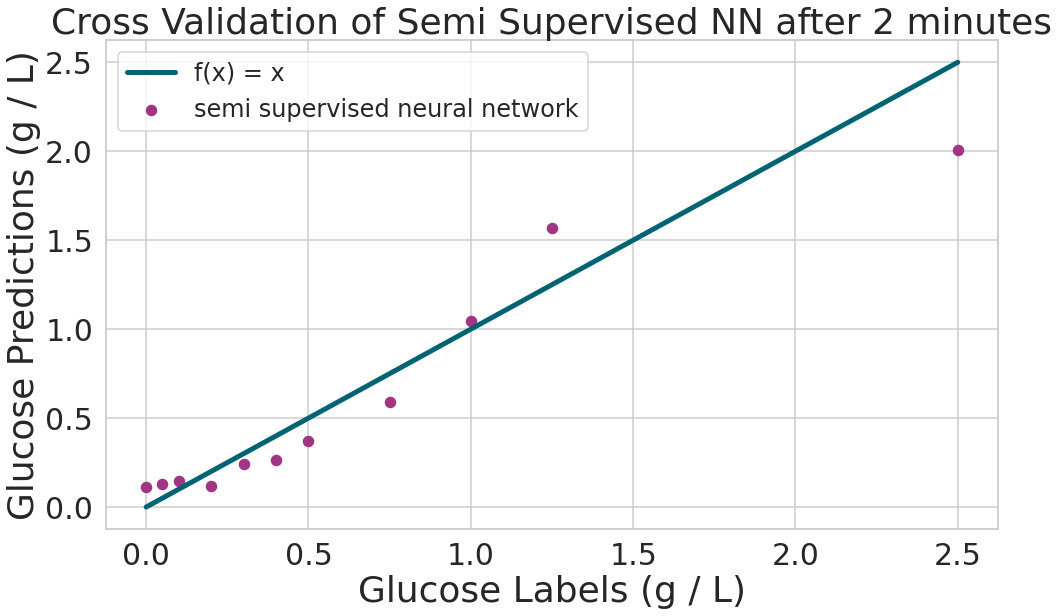

In [50]:
labels, predictions = zip(*results[20])


fig, ax = plt.subplots(1, 1,  figsize=(16, 9))

dark_colors = sns.color_palette("dark")

ax.scatter(labels, predictions, label='semi supervised neural network', color=dark_colors[6])
ax.plot(np.linspace(0., 2.5, 5), np.linspace(0., 2.5, 5), label='f(x) = x', color=dark_colors[9])
ax.legend()

ax.set_title('Cross Validation of Semi Supervised NN after 2 minutes')
ax.set_xlabel('Glucose Labels (g / L)')
ax.set_ylabel('Glucose Predictions (g / L)')

fig.savefig(
    os.path.join(
        FIG_DIR,
        'semi_supervised_two_minutes.png'
    ),
    transparent=True,    
)


In [21]:
with open('semi_supervised_nn.pickle', 'rb') as handle:
    results_dump = pickle.load(handle)
results_dump

{5: [(0, -0.09935246407985687),
  (0.05, -0.08356642723083496),
  (0.1, 0.08717821538448334),
  (0.2, 0.06351667642593384),
  (0.3, 0.48206090927124023),
  (0.4, 0.6174524426460266),
  (0.5, 0.6570452451705933),
  (0.75, 0.754478931427002),
  (1.0, 0.8179340362548828),
  (1.25, 1.2743946313858032),
  (2.5, 1.8243194818496704)],
 10: [(0, 0.10553429275751114),
  (0.05, 0.07431723922491074),
  (0.1, 0.14911536872386932),
  (0.2, 0.10736191272735596),
  (0.3, 0.3580118715763092),
  (0.4, 0.41374149918556213),
  (0.5, 0.4396304190158844),
  (0.75, 0.583857536315918),
  (1.0, 0.8835451006889343),
  (1.25, 1.5729117393493652),
  (2.5, 2.647444009780884)],
 15: [(0, 0.12955665588378906),
  (0.05, 0.10408727824687958),
  (0.1, 0.20717838406562805),
  (0.2, 0.14878948032855988),
  (0.3, 0.2485876977443695),
  (0.4, 0.3283690810203552),
  (0.5, 0.3212677240371704),
  (0.75, 0.5958511829376221),
  (1.0, 1.0000548362731934),
  (1.25, 1.5958292484283447),
  (2.5, 1.9721271991729736)],
 20: [(0, 0.1

In [11]:
leave_one_out_5 = [(label, float(prediction)) for label, prediction in labels_and_predictions]

NameError: name 'labels_and_predictions' is not defined

In [7]:
leave_one_out_2 = [(label, float(prediction)) for label, prediction in labels_and_predictions]

In [143]:
import copy

values_six_fold = [(label, float(prediction)) for label, prediction in labels_and_predictions]
values_six_fold

[(0, 0.2625137269496918),
 (0.4, 0.36631447076797485),
 (0.05, 0.20674267411231995),
 (2.5, 1.3225436210632324),
 (0.2, 0.23823042213916779),
 (0.3, 0.2859226167201996),
 (0.75, 0.6926344633102417),
 (1.0, 1.0617002248764038),
 (0.1, 0.24456003308296204),
 (1.25, 1.5634187459945679),
 (0.5, 0.3329315781593323)]

In [9]:
import itertools

val_performance = {}

def train_lstm(lstm_reg, dense_reg, units):
    
    print('lstm_reg: %.2E\n dense_reg: %.2E\n units: %s' % (lstm_reg, dense_reg, units))
    model = glucose_ts.models.VariableLSTM(
        units=18,
        total_length=100,
        label_length=100 - CUT_OFF_IDX,
        lstm_regularization=2e-8,
        dense_regularization=1e-8,
        norm_mean=0.,
        norm_std=1.,
        lstm_dropout=0.0,
        dense_dropout=0.0,
        dense_layer_sizes=(10, 5), 
    )

    with tf.device("GPU:0"):

        history, model = compile_and_fit_random(
            model,
            training_set=training.shuffle(100).prefetch(tf.data.AUTOTUNE),
            validation_set=validation,
            patience=20,
            epochs=200,
            lr=1e-4,
            steps_per_epoch=500,
        )

    val_performance['AR LSTM'] = model.evaluate(validation)
    model.summary()
    return model, history
# glucose_ts.data.plot(validation.shuffle(100).take(1), model)


cv_results = dict()
dropout_values = [0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32]
reg_values = np.logspace(-8, -4, 10)
combinations = list(itertools.product([5e-10, 1e-9, 2e-9, 5e-9], [5e-9, 1e8], [14, 16, 18, 20, 22, 24]))

print('number of combinations is %s' % len(combinations))

with tf.device("GPU:0"):

    for parameter in (combinations)[25:]:
#         print('Number %s of %s' % (idx + 1, len(combinations)))
        cv_results[parameter] = train_lstm(*parameter)

number of combinations is 48
lstm_reg: 2.00E-09
 dense_reg: 5.00E-09
 units: 16
Epoch 1/200
500/500 [==============================] - 30s 35ms/step - loss: 0.4294 - val_loss: 0.4257
Epoch 2/200
500/500 [==============================] - 17s 34ms/step - loss: 0.2196 - val_loss: 0.2290
Epoch 3/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1247 - val_loss: 0.2644
Epoch 4/200
500/500 [==============================] - 17s 35ms/step - loss: 0.1076 - val_loss: 0.2495
Epoch 5/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1004 - val_loss: 0.2420
Epoch 6/200
500/500 [==============================] - 17s 35ms/step - loss: 0.0918 - val_loss: 0.2319
Epoch 7/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0841 - val_loss: 0.2187
Epoch 8/200
500/500 [==============================] - 17s 35ms/step - loss: 0.0780 - val_loss: 0.2070
Epoch 9/200
500/500 [==============================] - 17s 35ms/step - loss: 0.0732 - val_loss: 

500/500 [==============================] - 18s 36ms/step - loss: 0.0432 - val_loss: 0.0584
Epoch 80/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0456 - val_loss: 0.0736
Epoch 81/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0423 - val_loss: 0.0502
Epoch 82/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0490 - val_loss: 0.0509
Epoch 83/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0433 - val_loss: 0.0521
Epoch 84/200
500/500 [==============================] - 18s 36ms/step - loss: 0.0433 - val_loss: 0.0442
Epoch 85/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0538 - val_loss: 0.0642
Epoch 86/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0393 - val_loss: 0.0485
Epoch 87/200
500/500 [==============================] - 17s 35ms/step - loss: 0.0410 - val_loss: 0.0558
Epoch 88/200
500/500 [==============================] - 17s 35ms/step - loss:

500/500 [==============================] - 17s 34ms/step - loss: 0.0521 - val_loss: 0.1059
Epoch 69/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0509 - val_loss: 0.1072
Epoch 70/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0497 - val_loss: 0.0712
Epoch 71/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0797 - val_loss: 0.1006
Epoch 72/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0641 - val_loss: 0.0866
Epoch 73/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1650 - val_loss: 0.1226
Epoch 74/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0892 - val_loss: 0.1149
Epoch 75/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0470 - val_loss: 0.0892
Epoch 76/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0486 - val_loss: 0.0849
Epoch 77/200
500/500 [==============================] - 17s 34ms/step - loss:

Epoch 96/200
500/500 [==============================] - 22s 44ms/step - loss: 0.0357 - val_loss: 0.0265
Epoch 97/200
500/500 [==============================] - 23s 46ms/step - loss: 0.0295 - val_loss: 0.0310
Epoch 98/200
500/500 [==============================] - 22s 44ms/step - loss: 0.0293 - val_loss: 0.0231
Epoch 99/200
500/500 [==============================] - 23s 45ms/step - loss: 0.0305 - val_loss: 0.0225
Epoch 100/200
500/500 [==============================] - 24s 47ms/step - loss: 0.0302 - val_loss: 0.0253
Epoch 101/200
500/500 [==============================] - 21s 43ms/step - loss: 0.0393 - val_loss: 0.0237
Epoch 102/200
500/500 [==============================] - 22s 45ms/step - loss: 0.0299 - val_loss: 0.0199
Epoch 103/200
500/500 [==============================] - 25s 50ms/step - loss: 0.0283 - val_loss: 0.0206
Epoch 104/200
500/500 [==============================] - 21s 42ms/step - loss: 0.0319 - val_loss: 0.0895
Epoch 105/200
500/500 [==============================] - 24

500/500 [==============================] - 40s 45ms/step - loss: 0.5160 - val_loss: 0.2628
Epoch 2/200
500/500 [==============================] - 22s 45ms/step - loss: 0.1459 - val_loss: 0.2251
Epoch 3/200
500/500 [==============================] - 27s 53ms/step - loss: 0.1197 - val_loss: 0.2310
Epoch 4/200
500/500 [==============================] - 22s 43ms/step - loss: 0.1124 - val_loss: 0.2323
Epoch 5/200
500/500 [==============================] - 23s 47ms/step - loss: 0.1071 - val_loss: 0.2323
Epoch 6/200
500/500 [==============================] - 23s 45ms/step - loss: 0.1025 - val_loss: 0.2244
Epoch 7/200
500/500 [==============================] - 22s 44ms/step - loss: 0.0965 - val_loss: 0.2182
Epoch 8/200
500/500 [==============================] - 22s 44ms/step - loss: 0.0894 - val_loss: 0.2112
Epoch 9/200
500/500 [==============================] - 22s 44ms/step - loss: 0.0822 - val_loss: 0.2005
Epoch 10/200
500/500 [==============================] - 22s 44ms/step - loss: 0.0747 

Epoch 80/200
500/500 [==============================] - 18s 36ms/step - loss: 0.0426 - val_loss: 0.0514
Epoch 81/200
500/500 [==============================] - 18s 36ms/step - loss: 0.0417 - val_loss: 0.0446
Epoch 82/200
500/500 [==============================] - 18s 36ms/step - loss: 0.0361 - val_loss: 0.0475
Epoch 83/200
500/500 [==============================] - 18s 37ms/step - loss: 0.0666 - val_loss: 0.0532
Epoch 84/200
500/500 [==============================] - 19s 38ms/step - loss: 0.0368 - val_loss: 0.0418
Epoch 85/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0391
Model: "variable_lstm_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_cell_5 (LSTMCell)       multiple                  1440      
_________________________________________________________________
rnn_5 (RNN)                  multiple                  1440      
_____________________________________________

500/500 [==============================] - 17s 35ms/step - loss: 0.0323 - val_loss: 0.0352
Epoch 144/200
500/500 [==============================] - 19s 38ms/step - loss: 0.0299 - val_loss: 0.0327
Epoch 145/200
500/500 [==============================] - 17s 35ms/step - loss: 0.0318 - val_loss: 0.0232
Epoch 146/200
500/500 [==============================] - 17s 35ms/step - loss: 0.0301 - val_loss: 0.0293
Epoch 147/200
500/500 [==============================] - 18s 36ms/step - loss: 0.0331 - val_loss: 0.0361
Epoch 148/200
500/500 [==============================] - 19s 38ms/step - loss: 0.0314 - val_loss: 0.0300
Epoch 149/200
500/500 [==============================] - 19s 39ms/step - loss: 0.0301 - val_loss: 0.0328
Epoch 150/200
500/500 [==============================] - 19s 37ms/step - loss: 0.0309 - val_loss: 0.0305
Epoch 151/200
500/500 [==============================] - 17s 35ms/step - loss: 0.0287 - val_loss: 0.0243
Epoch 152/200
500/500 [==============================] - 18s 35ms/ste

500/500 [==============================] - 19s 38ms/step - loss: 0.0554 - val_loss: 0.1619
Epoch 14/200
500/500 [==============================] - 20s 40ms/step - loss: 0.0550 - val_loss: 0.1668
Epoch 15/200
500/500 [==============================] - 19s 38ms/step - loss: 0.0547 - val_loss: 0.1574
Epoch 16/200
500/500 [==============================] - 19s 38ms/step - loss: 0.0536 - val_loss: 0.1532
Epoch 17/200
500/500 [==============================] - 19s 39ms/step - loss: 0.0534 - val_loss: 0.1574
Epoch 18/200
500/500 [==============================] - 19s 39ms/step - loss: 0.0530 - val_loss: 0.1614
Epoch 19/200
500/500 [==============================] - 19s 39ms/step - loss: 0.0525 - val_loss: 0.1476
Epoch 20/200
500/500 [==============================] - 19s 38ms/step - loss: 0.0520 - val_loss: 0.1462
Epoch 21/200
500/500 [==============================] - 19s 38ms/step - loss: 0.0517 - val_loss: 0.1437
Epoch 22/200
500/500 [==============================] - 19s 38ms/step - loss:

Epoch 92/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0335 - val_loss: 0.0280
Epoch 93/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0312 - val_loss: 0.0278
Epoch 94/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0336 - val_loss: 0.0363
Epoch 95/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0354 - val_loss: 0.0339
Epoch 96/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0324 - val_loss: 0.0281
Epoch 97/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1701 - val_loss: 0.1488
Epoch 98/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0437 - val_loss: 0.0350
Epoch 99/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0325 - val_loss: 0.0314
Epoch 100/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1259 - val_loss: 0.1513
Epoch 101/200
4/4 [==============================] - 0s 16ms/st

500/500 [==============================] - 17s 34ms/step - loss: 0.1102 - val_loss: 0.2203
Epoch 5/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1019 - val_loss: 0.2152
Epoch 6/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0949 - val_loss: 0.2113
Epoch 7/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0889 - val_loss: 0.2101
Epoch 8/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0797 - val_loss: 0.2144
Epoch 9/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0744 - val_loss: 0.2065
Epoch 10/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0730 - val_loss: 0.2063
Epoch 11/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0712 - val_loss: 0.2017
Epoch 12/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0709 - val_loss: 0.2020
Epoch 13/200
500/500 [==============================] - 17s 34ms/step - loss: 0.06

Epoch 83/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0306 - val_loss: 0.0271
Epoch 84/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0299 - val_loss: 0.0257
Epoch 85/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0319 - val_loss: 0.0262
Epoch 86/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0296 - val_loss: 0.0377
Epoch 87/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0305 - val_loss: 0.0255
Epoch 88/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0324 - val_loss: 0.0324
Epoch 89/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0306 - val_loss: 0.0297
Epoch 90/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0282 - val_loss: 0.0287
Epoch 91/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0326 - val_loss: 0.0269
Epoch 92/200
500/500 [==============================] - 17s 34ms

Epoch 101/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0343 - val_loss: 0.0615
Epoch 102/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0481 - val_loss: 0.0497
Epoch 103/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0358 - val_loss: 0.0549
Epoch 104/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0333 - val_loss: 0.0600
Epoch 105/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0341 - val_loss: 0.0427
Epoch 106/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0372 - val_loss: 0.0530
Epoch 107/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0407 - val_loss: 0.0592
Epoch 108/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0389 - val_loss: 0.0416
Epoch 109/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0619 - val_loss: 0.0462
Epoch 110/200
500/500 [==============================] 

500/500 [==============================] - 30s 35ms/step - loss: 0.6805 - val_loss: 0.2603
Epoch 2/200
500/500 [==============================] - 17s 34ms/step - loss: 0.3883 - val_loss: 0.2183
Epoch 3/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1895 - val_loss: 0.2045
Epoch 4/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1642 - val_loss: 0.2108
Epoch 5/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1572 - val_loss: 0.2191
Epoch 6/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1420 - val_loss: 0.2415
Epoch 7/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1337 - val_loss: 0.2369
Epoch 8/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1168 - val_loss: 0.2252
Epoch 9/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0885 - val_loss: 0.2069
Epoch 10/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0829 

Epoch 80/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0508 - val_loss: 0.0526
Epoch 81/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0342 - val_loss: 0.0447
Epoch 82/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0384 - val_loss: 0.0386
Epoch 83/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0593 - val_loss: 0.0349
Epoch 84/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0364 - val_loss: 0.0314
Epoch 85/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0407 - val_loss: 0.0326
Epoch 86/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0280
Model: "variable_lstm_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_cell_12 (LSTMCell)      multiple                  1440      
_________________________________________________________________
rnn_12

500/500 [==============================] - 17s 34ms/step - loss: 0.0602 - val_loss: 0.1827
Epoch 24/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0591 - val_loss: 0.1796
Epoch 25/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0586 - val_loss: 0.1813
Epoch 26/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0577 - val_loss: 0.1808
Epoch 27/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0567 - val_loss: 0.1799
Epoch 28/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0563 - val_loss: 0.1836
Epoch 29/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0557 - val_loss: 0.1846
Epoch 30/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0547 - val_loss: 0.1743
Epoch 31/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0544 - val_loss: 0.1754
Epoch 32/200
500/500 [==============================] - 17s 34ms/step - loss:

500/500 [==============================] - 17s 34ms/step - loss: 0.0395 - val_loss: 0.1276
Epoch 35/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0380 - val_loss: 0.1351
Epoch 36/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0380 - val_loss: 0.0855
Epoch 37/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0365 - val_loss: 0.0823
Epoch 38/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0352 - val_loss: 0.0967
Epoch 39/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0351 - val_loss: 0.0714
Epoch 40/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0343 - val_loss: 0.0716
Epoch 41/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0336 - val_loss: 0.0555
Epoch 42/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0334 - val_loss: 0.0559
Epoch 43/200
500/500 [==============================] - 17s 34ms/step - loss:

Epoch 113/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0237 - val_loss: 0.0248
Epoch 114/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0229 - val_loss: 0.0332
Epoch 115/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0233 - val_loss: 0.0237
Epoch 116/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0258 - val_loss: 0.0243
Epoch 117/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0217 - val_loss: 0.0243
Epoch 118/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0225 - val_loss: 0.0207
Epoch 119/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0226 - val_loss: 0.0259
Epoch 120/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0231 - val_loss: 0.0238
Epoch 121/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0232 - val_loss: 0.0210
Epoch 122/200
500/500 [==============================] 

500/500 [==============================] - 17s 34ms/step - loss: 0.0707 - val_loss: 0.0777
Epoch 31/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0422 - val_loss: 0.0667
Epoch 32/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0624 - val_loss: 0.1062
Epoch 33/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1348 - val_loss: 0.4086
Epoch 34/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0535 - val_loss: 0.0754
Epoch 35/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0436 - val_loss: 0.0568
Epoch 36/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0459 - val_loss: 0.0666
Epoch 37/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1173 - val_loss: 0.0721
Epoch 38/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0422 - val_loss: 0.0827
Epoch 39/200
500/500 [==============================] - 17s 34ms/step - loss:

500/500 [==============================] - 17s 34ms/step - loss: 0.0509 - val_loss: 0.0793
Epoch 94/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0337 - val_loss: 0.0228
Epoch 95/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0333 - val_loss: 0.0276
Epoch 96/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0320 - val_loss: 0.0240
Epoch 97/200
500/500 [==============================] - 17s 34ms/step - loss: 0.2160 - val_loss: 0.1530
Epoch 98/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0611 - val_loss: 0.0888
Epoch 99/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0476 - val_loss: 0.0460
Epoch 100/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0411 - val_loss: 0.0364
Epoch 101/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0343 - val_loss: 0.0258
Epoch 102/200
500/500 [==============================] - 17s 34ms/step - lo

500/500 [==============================] - 17s 34ms/step - loss: 0.0286 - val_loss: 0.0221
Epoch 120/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0272 - val_loss: 0.0252
Epoch 121/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0283 - val_loss: 0.0235
Epoch 122/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0285 - val_loss: 0.0257
Epoch 123/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0273 - val_loss: 0.0274
Epoch 124/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0284 - val_loss: 0.0272
Epoch 125/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0277 - val_loss: 0.0281
Epoch 126/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0279 - val_loss: 0.0296
Epoch 127/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0287 - val_loss: 0.0258
Epoch 128/200
500/500 [==============================] - 17s 34ms/ste

500/500 [==============================] - 17s 34ms/step - loss: 0.0610 - val_loss: 0.1768
Epoch 21/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0610 - val_loss: 0.1741
Epoch 22/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0607 - val_loss: 0.1781
Epoch 23/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0603 - val_loss: 0.1805
Epoch 24/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0601 - val_loss: 0.1719
Epoch 25/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0597 - val_loss: 0.1692
Epoch 26/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0594 - val_loss: 0.1727
Epoch 27/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0596 - val_loss: 0.1815
Epoch 28/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0592 - val_loss: 0.1721
Epoch 29/200
500/500 [==============================] - 17s 34ms/step - loss:

Epoch 99/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0338 - val_loss: 0.0727
Epoch 100/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0350 - val_loss: 0.0501
Epoch 101/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0335 - val_loss: 0.0515
Epoch 102/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0334 - val_loss: 0.0486
Epoch 103/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0342 - val_loss: 0.0485
Epoch 104/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0331 - val_loss: 0.0474
Epoch 105/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0367 - val_loss: 0.0579
Epoch 106/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0364 - val_loss: 0.0572
Epoch 107/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0329 - val_loss: 0.0562
Epoch 108/200
500/500 [==============================] -

Epoch 8/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0770 - val_loss: 0.1944
Epoch 9/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0747 - val_loss: 0.1932
Epoch 10/200
500/500 [==============================] - 18s 36ms/step - loss: 0.0733 - val_loss: 0.1890
Epoch 11/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0709 - val_loss: 0.1879
Epoch 12/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0701 - val_loss: 0.1781
Epoch 13/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0682 - val_loss: 0.1819
Epoch 14/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0667 - val_loss: 0.1847
Epoch 15/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0654 - val_loss: 0.1769
Epoch 16/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0640 - val_loss: 0.1805
Epoch 17/200
500/500 [==============================] - 17s 34ms/s

500/500 [==============================] - 17s 34ms/step - loss: 0.0570 - val_loss: 0.1899
Epoch 32/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0565 - val_loss: 0.1801
Epoch 33/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0563 - val_loss: 0.1804
Epoch 34/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0558 - val_loss: 0.1775
Epoch 35/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0563 - val_loss: 0.1778
Epoch 36/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0556 - val_loss: 0.1828
Epoch 37/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0562 - val_loss: 0.1750
Epoch 38/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0552 - val_loss: 0.1859
Epoch 39/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0544 - val_loss: 0.1709
Epoch 40/200
500/500 [==============================] - 17s 34ms/step - loss:

Epoch 110/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0519 - val_loss: 0.0959
Epoch 111/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0439 - val_loss: 0.0542
Epoch 112/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0432 - val_loss: 0.0600
Epoch 113/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0440 - val_loss: 0.0650
Epoch 114/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0420 - val_loss: 0.0592
Epoch 115/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0435 - val_loss: 0.0735
Epoch 116/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0431 - val_loss: 0.0552
Epoch 117/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0446 - val_loss: 0.0640
Epoch 118/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0425 - val_loss: 0.1064
Epoch 119/200
500/500 [==============================] 

In [27]:
model.evaluate(validation)

7/7 [==============================] - 0s 14ms/step - loss: 0.0907


0.09069262444972992

Epoch 1/80
500/500 [==============================] - 32s 37ms/step - loss: 0.5437 - val_loss: 0.3717
Epoch 2/80
500/500 [==============================] - 17s 34ms/step - loss: 0.2627 - val_loss: 0.1620
Epoch 3/80
500/500 [==============================] - 18s 36ms/step - loss: 0.1516 - val_loss: 0.2072
Epoch 4/80
500/500 [==============================] - 17s 35ms/step - loss: 0.1445 - val_loss: 0.1742
Epoch 5/80
500/500 [==============================] - 17s 34ms/step - loss: 0.1387 - val_loss: 0.1744
Epoch 6/80
500/500 [==============================] - 17s 34ms/step - loss: 0.1376 - val_loss: 0.1782
Epoch 7/80
500/500 [==============================] - 17s 34ms/step - loss: 0.1358 - val_loss: 0.1418
Epoch 8/80
500/500 [==============================] - 17s 34ms/step - loss: 0.1345 - val_loss: 0.1560
Epoch 9/80
500/500 [==============================] - 17s 34ms/step - loss: 0.1346 - val_loss: 0.1883
Epoch 10/80
500/500 [==============================] - 17s 34ms/step - loss: 0.132

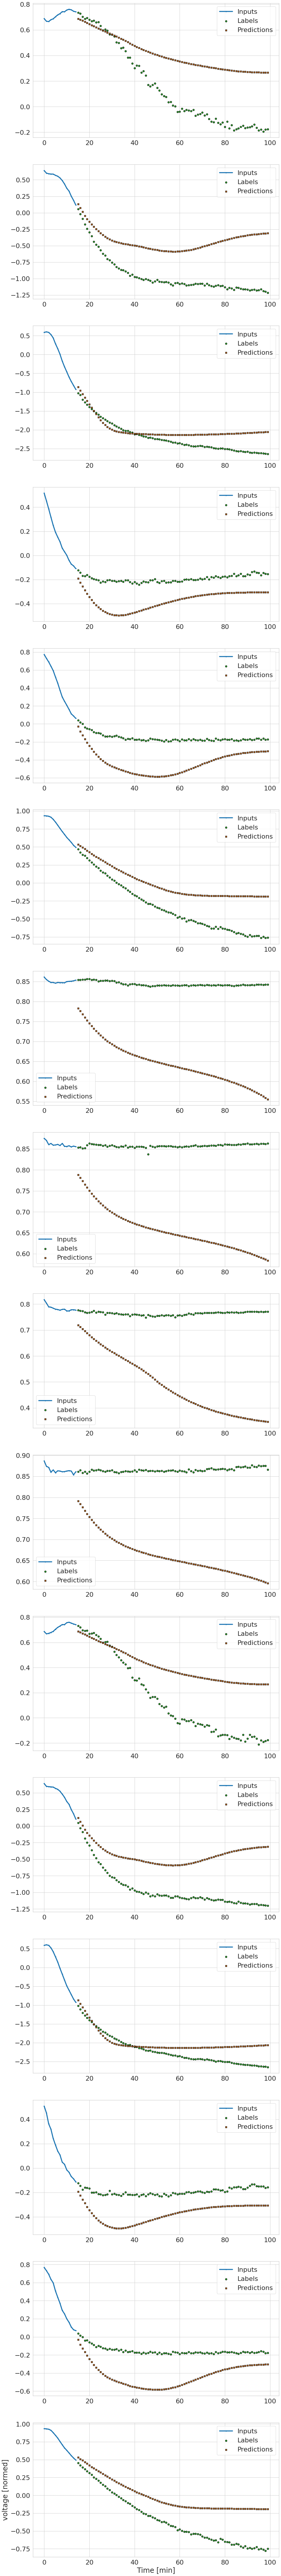

In [79]:
val_performance = {}

dropout_model = glucose_ts.models.VariableLSTM(
    units=20,
    total_length=100,
    label_length=100 - CUT_OFF_IDX,
    lstm_regularization=1e-8,
    dense_regularization=3e-4,
    norm_mean=0.,
    norm_std=1.,
    lstm_dropout=0.02,
    dense_dropout=0.0,
    dense_layer_sizes=(8, 4, ), 
)

with tf.device("CPU:0"):

    history, dropout_model = compile_and_fit_random(
        dropout_model,
        training_set=training.shuffle(100).prefetch(1000),
        validation_set=validation,
        patience=10,
        epochs=80,
        lr=1e-4,
        steps_per_epoch=500,
    )

val_performance['AR LSTM'] = dropout_model.evaluate(validation)
dropout_model.summary()
glucose_ts.data.plot(validation.shuffle(100).take(1), dropout_model)

In [10]:
model.evaluate(validation)

4/4 [==============================] - 0s 44ms/step - loss: 0.1214


0.12136317044496536

In [11]:
end_point = max(glucose_series[0].points_in_time)
points_in_time = np.linspace(0., end_point, 50)

len(points_in_time), int(CUT_OFF * LENGTH)

NameError: name 'LENGTH' is not defined

In [ ]:
train_mean, train_std, un_normalize(tf.constant([0., 0., 0.]), train_mean, train_std)

In [ ]:
LENGTH = 50

length = 5


fig, axises = plt.subplots(
    length,
    1,
    figsize=(15, 10 * length)
)

def un_normalize(data, mean, std):
    return tf.add(tf.multiply(data, tf.cast(std, dtype=data.dtype)), tf.cast(mean, dtype=data.dtype))


for ax, (inputs, labels) in zip(axises.flatten(), validation.unbatch().take(length)):
    predictions = model(inputs[tf.newaxis, :, :])
    
    voltage_inputs = un_normalize(inputs, train_mean, train_std)
    voltage_labels = un_normalize(labels, train_mean, train_std)
    voltage_predictions = un_normalize(predictions, train_mean, train_std)
    
    
    ax.set_ylabel('voltage [V]')
    ax.set_xlabel('time [min]')

    ax.plot(
        points_in_time[:int(CUT_OFF * LENGTH)],
        voltage_inputs,
        label='Inputs',
    )

    ax.plot(
        points_in_time[int(CUT_OFF * LENGTH):],
        voltage_labels,
        label='Labels',
    )
    ax.plot(
        points_in_time[int(CUT_OFF * LENGTH):],
        voltage_predictions[0, :, 0],
        label='Predictions',
    )
    
    ax.axvline(
        x=max(points_in_time) * CUT_OFF,
        label='cutoff',
        linestyle='--',
        color='crimson'
    )
    ax.legend()




In [ ]:
FINAL_THRESHOLD = 7.
final_voltage(tf.range(40))

In [ ]:
import math

FINAL_THRESHOLD = 7.
cut_off = math.ceil((FINAL_THRESHOLD / max(points_in_time) - CUT_OFF) * LENGTH)

def final_voltage(voltages):
    return tf.reduce_mean(voltages[cut_off:])
    
    
residuals = []

for inputs, labels in validation.unbatch():

    predictions = model(inputs[tf.newaxis, :, :])
    
    final_voltage_predictions = final_voltage(
        un_normalize(predictions, train_mean, train_std)[0, :, 0]
    )
    final_voltage_labels = final_voltage(
        un_normalize(labels, train_mean, train_std)[:, 0]
    )
    
    residuals.append(float(final_voltage_predictions - final_voltage_labels))
    
len(residuals)



In [ ]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(10, 10)
)



sns.histplot(residuals, kde=True, ax=ax)
ax.set_xlabel('predicted final voltage - final voltage', labelpad=20)
print(sum([one ** 2 for one in residuals]) / len(residuals))

In [ ]:
for ax, (inputs, labels) in zip(axises.flatten(), validation.unbatch().take(length)):
    predictions = model(inputs[tf.newaxis, :, :])
    
    voltage_inputs = un_normalize(inputs, train_mean, train_std)
    voltage_labels = un_normalize(labels, train_mean, train_std)
    voltage_predictions = un_normalize(predictions, train_mean, train_std)


In [ ]:
import collections

LSTM_Parameter = collections.namedtuple(
    'LSTM_Parameter',
    ['units', 
     'dropout',
     'lstm_reg', 'dense_reg',
     'learning_rate']
)

all_results_reg = []


for idx, params in enumerate(itertools.product(
    range(6, 16, 3),
    [0.],
    np.logspace(-7, -3, 3),
    np.logspace(-7, -3, 3),
    np.logspace(-3, -2, 3),
)):
    parameter = LSTM_Parameter(*params)
    
    print('number %s' % idx)
    print('units %s' % parameter.units)
    print('dropout %4.2f' % parameter.dropout)
    print('lstm reg %8.6f' % parameter.lstm_reg)
    print('dense reg %8.6f' % parameter.dense_reg)
    print('learning rate %8.6f' % parameter.learning_rate)
    
    
    results = glucose_ts.models.utils.cross_validation(
        dataset=normed_series,
        model=glucose_ts.models.VariableLSTM(
            units=parameter.units,
            total_length=50,
            label_length=40,
            lstm_regularization=parameter.lstm_reg,
            dense_regularization=parameter.dense_reg,
            lstm_dropout=parameter.dropout,
        ),
        num_folds=3,
        steps_per_epoch=500,
        epochs=30,
        patience=6,
        cut_off=.2,
        cluster_length=20,
        learning_rate=parameter.learning_rate,
    )
    print('results: %s' % results)
    all_results_reg.append((parameter, results))
    




In [ ]:
len(all_results_reg)

In [ ]:
all_units, all_dropout, all_lstm_reg, all_dense_reg, all_lrs = zip(*[one[0] for one in all_results_reg])
fold_1, fold_2, fold_3 = zip(*[one[1] for one in all_results_reg])

In [ ]:
hyper_tuning_reg = pd.DataFrame({
    'units': all_units,
    'dropout': all_dropout,
    'lstm_reg': all_lstm_reg,
    'dense_reg': all_dense_reg,
    'learning_rate': all_lrs,
    'fold_1': fold_1,
    'fold_2': fold_2,
    'fold_3': fold_3,
})
hyper_tuning_reg

In [ ]:
hyper_tuning = pd.DataFrame({
    'units': all_units,
    'dropout': all_dropout,
    'learning_rate': all_lrs,
    'fold_1': fold_1,
    'fold_2': fold_2,
    'fold_3': fold_3,
})
hyper_tuning_reg['avg_result'] = (hyper_tuning_reg['fold_1'] + hyper_tuning_reg['fold_2'] + hyper_tuning_reg['fold_3']) / 3
hyper_tuning_reg.sort_values(by=['avg_result'])

In [ ]:
hyper_tuning['avg_result'] = (hyper_tuning['fold_1'] + hyper_tuning['fold_2'] + hyper_tuning['fold_3']) / 3
hyper_tuning.to_csv('hyper_tuning_dropout.csv')

# Christoph's 2 cent

## Observations

The model learns one observation that fits all use-cases. If you look at the two plots the prediction curves are identical.

There is no smooth transition from the inputs to the predictions. You can see it with the two inputs. For the second one there is quite a smooth transition from the inputs to the predictions. For the first one there is a little jump from the input to the predictions.

## Conclusions

It does not really differentiate between the two validation examples.

The model does not learn the next prediction from the concrete last steps.


## Next steps

* Try dropout
* Make a systematic grid search
* try more data augmentation for generating more data
* GAN?
* Wait for more data
* physics informed network that learns the five parameters of the ODE
* try a smoothness regularization term?
* try a convolutional network


In [ ]:
os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'presenations', 'images', 'time_series_dataset.png')

In [ ]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(15, 10)
)


for series in glucose_series:   
    
    ax.set_ylabel('voltage [V]')
    ax.set_xlabel('time [min]')

    ax.plot(
        series.points_in_time,
        series.voltages,
    )
fig.savefig(os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'presentations', 'images', 'time_series_dataset.png'), transparent=True)